#### Imports and helper functions

In [8]:
#! /usr/bin/env python3
import rospkg
import pickle
import numpy as np
import pandas as pd
np.seterr(divide='ignore', invalid='ignore')
import copy
from tqdm.auto import tqdm

from pyaarapsi.vpr_simple.vpr_helpers       import FeatureType
from pyaarapsi.vpr_simple.vpr_dataset_tool  import VPRDatasetProcessor
from pyaarapsi.vpr_simple.svm_model_tool    import SVMModelProcessor
from pyaarapsi.core.helper_tools            import m2m_dist
from pyaarapsi.core.enum_tools              import enum_name
from pyaarapsi.core.transforms              import apply_homogeneous_transform, Transform_Builder
from pyaarapsi.pathing.basic                import calc_path_stats
from pyaarapsi.vpred.robotrun               import RobotRun
from pyaarapsi.vpred.robotvpr               import RobotVPR
from pyaarapsi.vpred.robotmonitor           import RobotMonitor2D
from pyaarapsi.vpred.vpred_tools            import find_precision_atR, find_recall_atP
from pyaarapsi.vpred.vpred_factors          import find_factors
from Experiment_0_Shared_Functions          import *

%matplotlib inline

# Core Config

In [37]:
DO_FILTERS              = False
USE_BIG_MONITORS        = True
SLICE_LENGTHS           = np.array([1.5])#np.arange(0.2,10.1,0.1)
SHOW_VPRDP_DIAGNOSTICS  = True
FORCE_GENERATE          = False
SKIP_SAVE               = False
FEATURE_TYPE            = FeatureType.SALAD # or RAW or NETVLAD (RAW is SAD)
SAMPLE_RATE             = 5

#### Parameters

In [38]:
# Define some indices to ensure no silly business later:
iVPR = 0
iSVM = 1
iNVP = 2
iNVR = 3
iGT_ = 4

cVPR = '#C5304B'
cNVP = '#F29E4C'
cNVR = '#EFEA5A'
cSVM = '#16DB93'
cGT_ = '#048BA8'

cRED = '#e63c3c'
cBLK = 'lightgrey'

mode_names  = {'vpr': 'VPR', 'nvp': '$N_P$', 'nvr': '$N_R$', 'svm': ' SVM (Ours)', 'gt': 'Ground Truth'}
hue_order   = [mode_names['vpr'], mode_names['nvp'], mode_names['nvr'], mode_names['svm']]
set_order   = ['Office\nNormal','Office\nAdverse','Campus\nNormal','Campus\nAdverse']
_palette    = {mode_names['vpr']: cVPR, mode_names['svm']: cSVM, mode_names['nvp']: cNVP, mode_names['nvr']: cNVR, mode_names['gt']: cGT_}
#thresholds  = {'Office': {'Precision': 2442.976953677679, 'Recall': 2088.2025703881936}, 'Campus': {'Precision': 3718.4704073226553, 'Recall': 4003.259997585375}}

root_path   = rospkg.RosPack().get_path("aarapsi_robot_pack")
npz_dbp     = "/data/compressed_sets"
svm_dbp     = "/cfg/svm_models"
bag_dbp     = "/data/rosbags"
odom_topic  = "/odom/true"
enc_topic   = "/jackal_velocity_controller/odom"
img_topics  = ["/ros_indigosdk_occam/image0/compressed"]
img_dims    = [64,64]
filters     = ''
if DO_FILTERS:
    qry_filter  = ''
    ref_filter  = '{"distance": 0.05}'
else:
    qry_filter  = filters
    ref_filter  = filters

sample_rate = SAMPLE_RATE
ft_type     = FEATURE_TYPE

def getfactors(_ft_type_in):
    if _ft_type_in == FeatureType.NETVLAD:
        factors  = ["area", "mlows"] # old
        # factors = ['vagradmult', 'IQRskew']
        # factors = ['va', 'IQRskew']
    elif _ft_type_in == FeatureType.RAW:
        factors  = ["grad", "va"]
    elif _ft_type_in == FeatureType.SALAD:
        factors  = ["senssum_all", "va"] # old
        # factors  = ["senssum_all", "va"] # current
        # factors  = ["grad", "md_medi"] # Okay!
        # factors = ["IQRskew","grad"] 
        # factors = ["grad","minima_indvar"] # good.
    else:
        raise Exception()
    return list(np.sort(factors))

tol_mode    = 'DISTANCE'

bags        = { 'Office': 
                {   'SVM':      {'ref': 'sim_cw_3', 'qry': 'sim_cw_5'}, 
                    'Normal':   {'ref': 's5_ccw_1', 'qry': 's6_ccw_1'},
                    'Adverse':  {'ref': 's4_cw_1',  'qry': 'lab_adv_2'}},
                'Campus': 
                {   'SVM':      {'ref': 'll_cw_1',  'qry': 'll_cw_3'}, 
                    'Normal':   {'ref': 'run3_fix', 'qry': 'run4_fix'},
                    'Adverse':  {'ref': 'run1_fix', 'qry': 'run5_ccw'}}          
            }

def make_ff_unique_fn_ext(feature_type = None):
    if feature_type is None:
        global FEATURE_TYPE
        feature_type = FEATURE_TYPE
    _fsorted = getfactors(feature_type)
    global DO_FILTERS
    _filt_ext = "_filt" if DO_FILTERS else ""
    global USE_BIG_MONITORS
    _big_monitor_ext = "_using_big_monitors" if USE_BIG_MONITORS else ""
    global SAMPLE_RATE
    _sample_rate_ext = str(int(SAMPLE_RATE))
    global FF_UNIQUE_FN_EXT
    FF_UNIQUE_FN_EXT = "_" + feature_type.name + "_" + _fsorted[0] + "_" + _fsorted[1] + "_" + _sample_rate_ext + _filt_ext + _big_monitor_ext
    return FF_UNIQUE_FN_EXT

FACTORS_SORTED          = getfactors(ft_type)
FF_UNIQUE_FN_EXT        = make_ff_unique_fn_ext()

#### Helper Functions

In [39]:
def calc_ablation_stats(raw_, bad_, start_ind_, decision_ind_, data_dict_, wo_sum_, vpr_sum_, vpr_xy_, gt_pos_):
    raw_est_min             = np.argmin(raw_[start_ind_:decision_ind_]) + start_ind_                        # best-match filtered vpr by match distance
    if raw_est_min in bad_:                                                                                 # if bad:
        raw_est_pos_err     = np.nan                                                                            # then we can't do anything
        raw_est_min         = np.nan
        raw_est_sum_so_far  = np.nan
        raw_est_now_ind     = np.nan
    else:                                                                                                   # if good:
        raw_est_ind         = data_dict_['mInd'][raw_est_min]                                                   # then corresponding best-match index in ref data
        raw_est_sum_so_far  = sum_dist(wo_sum_, decision_ind_, raw_est_min)                                     # since best-match, how much movement?
        raw_est_now_ind     = np.argmin(abs(np.array(vpr_sum_) - (vpr_sum_[raw_est_ind] + raw_est_sum_so_far))) # what is current position index along the vpr path?
        raw_est_pos_now     = vpr_xy_[raw_est_now_ind,:]                                                        # what is current position?
        raw_est_pos_err     = np.sqrt(np.sum(np.square(gt_pos_    - raw_est_pos_now)))                          # how much error is in the position estimate?
    return raw_est_pos_err, raw_est_min, raw_est_now_ind, raw_est_sum_so_far

def gen_data_dict(_qry_feats, _wo_odom, _gt_odom, _ft_type, _img_dims, _ref_ip, _svm, _tol_thres, _naive_p_thresh, _naive_r_thresh, use_tqdm=True):
    # Create array of ground truth odometry (xyw), wheel encoder odometry (xyw), EKF filtered odometry (xyw), 
    # VPR match index, VPR match distance, VPR true index, VPR true distance
    # ground truth classification, ground truth error
    # SVM prediction, SVM probability, SVM z value

    # Initialise dictionary:
    _data_dict          = dict(gt_xyw=_gt_odom, wo_xyw=_wo_odom, 
                            mInd=[], mDist=[], tInd=[], tDist=[], 
                            gt_class=[], gt_err=[], 
                            svm_pred=[], svm_prob=[], svm_z=[],
                            feats=[])

    _state_hist         = np.zeros((10,3)) # state history of matched x,y,w

    if use_tqdm:
        iter_obj = tqdm(range(_qry_feats.shape[0]))
    else:
        iter_obj = range(_qry_feats.shape[0])

    for i in iter_obj:
        _new_qry        = _qry_feats[i]
        _features       = _ref_ip.dataset['dataset'][enum_name(_ft_type)]

        _dvc            = m2m_dist(_features, np.matrix(_new_qry), True)
        _squares        = np.square(np.array(_ref_ip.dataset['dataset']['px']) - _data_dict['gt_xyw'][i,0]) + \
                          np.square(np.array(_ref_ip.dataset['dataset']['py']) - _data_dict['gt_xyw'][i,1])
        _mInd           = np.argmin(_dvc)
        _tInd           = np.argmin(_squares)
        _tolError       = np.sqrt(np.square(_ref_ip.dataset['dataset']['px'][_tInd] - _ref_ip.dataset['dataset']['px'][_mInd]) + \
                                  np.square(_ref_ip.dataset['dataset']['py'][_tInd] - _ref_ip.dataset['dataset']['py'][_mInd]))
        _rXY             = np.stack([_ref_ip.dataset['dataset']['px'], _ref_ip.dataset['dataset']['py']], 1)
        if isinstance(_svm, SVMModelProcessor):
            (_pred, _zval, _factors, _prob) = _svm.predict(_dvc, _mInd, _rXY, init_pos=_state_hist[1, 0:2])
        elif isinstance(_svm, RobotMonitor2D):
            _factors_out = find_factors(factors_in=_svm.factor_names, _S=_dvc, 
                                        rXY=_rXY, mInd=_mInd, init_pos=_state_hist[1, 0:2], return_as_dict=True)
            _factors = np.c_[[_factors_out[i] for i in _svm.factor_names]]
            if _factors.shape[1] == 1:
                _factors = np.transpose(_factors)                   # put the factors into a column vector
            X_scaled = _svm.scaler.transform(X=_factors)            # perform scaling using same parameters as calibration set
            _zval    = _svm.model.decision_function(X=X_scaled)[0]  # 'z' value; not probability but "related"...
            _pred    = _svm.model.predict(X=X_scaled)[0]            # Make the prediction: predict whether this match is good or bad
            _prob    = _svm.model.predict_proba(X=X_scaled)[:,1]    # get probability of prediction

        if _pred:
            _state_hist[0,:] = [_ref_ip.dataset['dataset']['px'][_mInd], _ref_ip.dataset['dataset']['py'][_mInd], _ref_ip.dataset['dataset']['pw'][_mInd]]
            _state_hist      = np.roll(_state_hist, 1, 0)
        _data_dict['mInd'].append(    _mInd)
        _data_dict['tInd'].append(    _tInd)
        _data_dict['mDist'].append(   _dvc[_mInd])
        _data_dict['tDist'].append(   _dvc[_tInd])
        _data_dict['gt_class'].append(_tolError < _tol_thres)
        _data_dict['gt_err'].append(  _tolError)
        _data_dict['svm_pred'].append(_pred)
        _data_dict['svm_prob'].append(_prob)
        _data_dict['svm_z'].append(   _zval)
        _data_dict['feats'].append(   _new_qry)

    # Convert to numpy array:
    for k in _data_dict:
        _data_dict[k]    = np.array(_data_dict[k])

    # Apply naive thresholds:
    _data_dict['naive_p'] = []
    _data_dict['naive_r'] = []
    for mDist in _data_dict['mDist']:
        _data_dict['naive_p'].append(mDist <= _naive_p_thresh)
        _data_dict['naive_r'].append(mDist <= _naive_r_thresh)
    _data_dict['naive_p'] = np.array(_data_dict['naive_p'])
    _data_dict['naive_r'] = np.array(_data_dict['naive_r'])

    return _data_dict

def generate_data(_sample_rate, _tol_thres, _environment, _condition, _slice_lengths, _df=None, _single_frame=False):
    global bags, root_path, npz_dbp, svm_dbp, bag_dbp, odom_topic, enc_topic, img_topics, ft_type
    global img_dims, filters, ref_filter, qry_filter, FACTORS_SORTED, tol_mode, iVPR, iSVM, iNVP, iNVR, iGT_, mode_names, USE_BIG_MONITORS
    global ip, pass_nn_args, kwargs_ip

    print('Generating for', _environment, _condition)

    ref_dict        = dict( bag_name=bags[_environment][_condition]['ref'], npz_dbp=npz_dbp, bag_dbp=bag_dbp, \
                            odom_topic=odom_topic, img_topics=img_topics, sample_rate=_sample_rate, \
                            ft_types=[ft_type.name], img_dims=img_dims, filters=ref_filter)
    qry_dict        = dict( bag_name=bags[_environment][_condition]['qry'], npz_dbp=npz_dbp, bag_dbp=bag_dbp, \
                            odom_topic=[odom_topic, enc_topic], img_topics=img_topics, sample_rate=_sample_rate, \
                            ft_types=[ft_type.name], img_dims=img_dims, filters=qry_filter)
    svm_ref_dict    = dict( bag_name=bags[_environment]['SVM']['ref'], npz_dbp=npz_dbp, bag_dbp=bag_dbp, \
                            odom_topic=odom_topic, img_topics=img_topics, sample_rate=_sample_rate, \
                            ft_types=[ft_type.name], img_dims=img_dims, filters=ref_filter)
    svm_qry_dict    = dict( bag_name=bags[_environment]['SVM']['qry'], npz_dbp=npz_dbp, bag_dbp=bag_dbp, \
                            odom_topic=odom_topic, img_topics=img_topics, sample_rate=_sample_rate, \
                            ft_types=[ft_type.name], img_dims=img_dims, filters=qry_filter)
    svm_svm_dict    = dict(factors=FACTORS_SORTED, tol_thres=_tol_thres, tol_mode=tol_mode)
    svm_dict        = dict(ref=svm_ref_dict, qry=svm_qry_dict, svm=svm_svm_dict, npz_dbp=npz_dbp, bag_dbp=bag_dbp, svm_dbp=svm_dbp)

    ref_ip          = VPRDatasetProcessor(None, try_gen=True, cuda=True, autosave=True, ros=False, **kwargs_ip)
    qry_ip          = VPRDatasetProcessor(None, try_gen=True, cuda=True, autosave=True, ros=False, **kwargs_ip)

    ref_ip.pass_nns(ip, **pass_nn_args)
    qry_ip.pass_nns(ip, **pass_nn_args)

    ref_ip.load_dataset(ref_dict, try_gen=True)
    qry_ip.load_dataset(qry_dict, try_gen=True)

    _qry_feats      = qry_ip.dataset['dataset'][enum_name(ft_type)]
    _gt_odom        = np.transpose(np.stack([qry_ip.dataset['dataset']['px'][:,0], qry_ip.dataset['dataset']['py'][:,0], qry_ip.dataset['dataset']['pw'][:,0]]))
    _wo_odom        = np.transpose(np.stack([qry_ip.dataset['dataset']['px'][:,1], qry_ip.dataset['dataset']['py'][:,1], qry_ip.dataset['dataset']['pw'][:,1]]))

    metric_names = ['p','r','tp','fp','tn','fn','d']

    if not USE_BIG_MONITORS:
        svm             = SVMModelProcessor(ros=False, **kwargs_ip)
        svm.pass_nns(ip, **pass_nn_args)
        print(svm.load_model(svm_dict, try_gen=True, gen_datasets=True, save_datasets=True))
        svm.generate_missing_variables()

        train_ref_robotrun = RobotRun(folder="", npz_setup=True).from_dataset_processor(svm.cal_ref_ip)
        train_qry_robotrun = RobotRun(folder="", npz_setup=True).from_dataset_processor(svm.cal_qry_ip)
        train_robotvpr     = RobotVPR(train_ref_robotrun, train_qry_robotrun, norm=False)
        train_robotvpr.assess_performance(_tol_thres, 'm', verbose=False)

        cl_metrics=pd.Series(data=train_robotvpr.compute_cl_PRcurve_metrics(svm.predict_quality()),index=(metric_names))

    else:
        from big_monitor import FUSED_MONITORS
        svm = FUSED_MONITORS[ft_type.name]
        assert isinstance(svm, RobotMonitor2D)
        train_robotvpr = svm.vpr

        cl_metrics=pd.Series(data=train_robotvpr.compute_cl_PRcurve_metrics(svm.predict_quality(train_robotvpr)),index=metric_names)

    bl_metrics=pd.Series(data=train_robotvpr.compute_PRcurve_metrics(),index=metric_names)
    
    _, _, matchR_d = find_precision_atR(bl_metrics.p,bl_metrics.r,cl_metrics.r[-1],verbose=False)
    _, _, matchP_d = find_recall_atP(bl_metrics.p,bl_metrics.r,cl_metrics.p[-1],verbose=False)

    _naive_p_thresh, _naive_r_thresh = bl_metrics.d[matchP_d], bl_metrics.d[matchR_d]

    # Generate query data:
    data_dict           = gen_data_dict(_qry_feats, _wo_odom, _gt_odom, ft_type, img_dims, ref_ip, svm, _tol_thres, _naive_p_thresh, _naive_r_thresh, use_tqdm=False)

    _len_queries        = len(data_dict['mInd'])

    wo_sum, wo_len      = calc_path_stats(data_dict['wo_xyw'][:,0:2])

    dd_ind_min          = np.argmin(abs(wo_sum - np.max(_slice_lengths))) + 1
    dd_ind_max          = _len_queries

    _len = qry_ip.dataset['dataset']['px'].shape[0]
    print('Using indices %d to %d (%0.2f%% of %d)' % (dd_ind_min, dd_ind_max, (100 * (dd_ind_max - dd_ind_min) / _len), _len))

    vpr_xy              = np.transpose(np.stack([ref_ip.dataset['dataset']['px'], ref_ip.dataset['dataset']['py']]))
    vpr_sum, vpr_len    = calc_path_stats(vpr_xy)

    svm_raw             = copy.deepcopy(data_dict['mDist'])
    svm_bad             = np.arange(_len_queries)[np.array(data_dict['svm_pred']) == False]
    svm_raw[svm_bad]    = np.max(svm_raw)   

    nvp_raw             = copy.deepcopy(data_dict['mDist'])
    nvp_bad             = np.arange(_len_queries)[np.array(data_dict['naive_p']) == False]
    nvp_raw[nvp_bad]    = np.max(nvp_raw) 

    nvr_raw             = copy.deepcopy(data_dict['mDist'])
    nvr_bad             = np.arange(_len_queries)[np.array(data_dict['naive_r']) == False]
    nvr_raw[nvr_bad]    = np.max(nvr_raw)

    if _df is None:
        data_frame      = pd.DataFrame(columns=['pos_error', 'mInd', 'lInd', 'wo_dist', 'mode', 'MODE', 'possible', 'slice_length', 'decision_index', 'start_index', 
                                                'environment', 'condition', 'tol_thres'], 
                                    index=list(range(_slice_lengths.shape[0] * (dd_ind_max - dd_ind_min) * 4)))
    else:
        data_frame      = _df

    df_counter = 0
    for slice_length in _slice_lengths:
        for decision_ind in range(dd_ind_min,dd_ind_max):

            if not _single_frame:
                # Search to find start index; only look at matches since then:
                start_ind           = np.argmin(abs(np.array(wo_sum) - (wo_sum[decision_ind] - slice_length)))
                while abs(wo_sum[decision_ind] - wo_sum[start_ind]) < slice_length:
                    start_ind       = start_ind - 1
            else:
                start_ind = decision_ind - 1

            # Find ground truth current position:
            gt_pos              = data_dict['gt_xyw'][decision_ind,0:2]

            # check if possible:
            possible            = True in data_dict['gt_class'][start_ind:decision_ind]

            # Ensure no silly business with indices:
            est_pos_err_list            = [None] * 4
            est_ind_list                = [None] * 4
            est_wo_dist_list            = [None] * 4
            est_now_ind_list            = [None] * 4

            est_pos_err_list[iVPR], est_ind_list[iVPR], est_now_ind_list[iVPR], est_wo_dist_list[iVPR] = calc_ablation_stats(data_dict['mDist'],      [], start_ind, decision_ind, data_dict, wo_sum, vpr_sum, vpr_xy, gt_pos)
            est_pos_err_list[iSVM], est_ind_list[iSVM], est_now_ind_list[iSVM], est_wo_dist_list[iSVM] = calc_ablation_stats(svm_raw,            svm_bad, start_ind, decision_ind, data_dict, wo_sum, vpr_sum, vpr_xy, gt_pos)
            est_pos_err_list[iNVP], est_ind_list[iNVP], est_now_ind_list[iNVP], est_wo_dist_list[iNVP] = calc_ablation_stats(nvp_raw,            nvp_bad, start_ind, decision_ind, data_dict, wo_sum, vpr_sum, vpr_xy, gt_pos)
            est_pos_err_list[iNVR], est_ind_list[iNVR], est_now_ind_list[iNVR], est_wo_dist_list[iNVR] = calc_ablation_stats(nvr_raw,            nvr_bad, start_ind, decision_ind, data_dict, wo_sum, vpr_sum, vpr_xy, gt_pos)

            # Generate pandas data frame entries:
            same_entries                            = [possible, slice_length, decision_ind, start_ind, _environment, _condition, _tol_thres]
            data_frame.iloc[(df_counter*4) + iVPR]  = [est_pos_err_list[iVPR], est_ind_list[iVPR], est_now_ind_list[iVPR], est_wo_dist_list[iVPR], 'vpr', mode_names['vpr']] + same_entries
            data_frame.iloc[(df_counter*4) + iSVM]  = [est_pos_err_list[iSVM], est_ind_list[iSVM], est_now_ind_list[iSVM], est_wo_dist_list[iSVM], 'svm', mode_names['svm']] + same_entries
            data_frame.iloc[(df_counter*4) + iNVP]  = [est_pos_err_list[iNVP], est_ind_list[iNVP], est_now_ind_list[iNVP], est_wo_dist_list[iNVP], 'nvp', mode_names['nvp']] + same_entries
            data_frame.iloc[(df_counter*4) + iNVR]  = [est_pos_err_list[iNVR], est_ind_list[iNVR], est_now_ind_list[iNVR], est_wo_dist_list[iNVR], 'nvr', mode_names['nvr']] + same_entries

            df_counter = df_counter + 1

    return data_frame, data_dict

def do_experiment(_slice_lengths: list, _single_frame: bool = False):
    df_ln, qd_ln = generate_data(   _sample_rate=sample_rate, _tol_thres=0.5, _environment='Office', _condition='Normal',  
                                    _slice_lengths=_slice_lengths, _single_frame=_single_frame)
    df_la, qd_la = generate_data(   _sample_rate=sample_rate, _tol_thres=0.5, _environment='Office', _condition='Adverse', 
                                    _slice_lengths=_slice_lengths, _single_frame=_single_frame)
    df_cn, qd_cn = generate_data(   _sample_rate=sample_rate, _tol_thres=1.0, _environment='Campus', _condition='Normal',  
                                    _slice_lengths=_slice_lengths, _single_frame=_single_frame)
    df_ca, qd_ca = generate_data(   _sample_rate=sample_rate, _tol_thres=1.0, _environment='Campus', _condition='Adverse', 
                                    _slice_lengths=_slice_lengths, _single_frame=_single_frame)

    df = pd.concat([df_cn, df_ca, df_ln, df_la])

    # Extra columns:
    df['in_tol']    = (df['pos_error'] < df['tol_thres'])
    df['discard']   = df['pos_error'].isnull() 
    df['success']   = df['in_tol'] & (df['discard'] == False)
    df['set']       = df['environment'] + '\n' + df['condition']

    df['TN'] = (df['possible']==False) & (df['discard']==True )
    df['FN'] = (df['possible']==True ) & (df['discard']==True )
    df['TP'] = (df['possible']==True ) & (df['discard']==False)
    df['FP'] = (df['possible']==False) & (df['discard']==False)

    _len = len(df['TN'])
    _type = np.array([' '*3] * _len)
    _type[np.arange(_len)[df['TN']]] = 'TN'
    _type[np.arange(_len)[df['FN']]] = 'FN'
    _type[np.arange(_len)[df['TP']]] = 'TP'
    _type[np.arange(_len)[df['FP']]] = 'FP'
    df['type'] = _type

    _TYPE = np.array([' '*16] * _len)
    _TYPE[np.arange(_len)[df['TN']]] = 'True\nNegative'
    _TYPE[np.arange(_len)[df['FN']]] = 'False\nNegative'
    _TYPE[np.arange(_len)[df['TP']]] = 'True\nPositive'
    _TYPE[np.arange(_len)[df['FP']]] = 'False\nPositive'
    df['TYPE'] = _TYPE
    return df, qd_ln, qd_la, qd_cn, qd_ca

#### Perform Experiment

In [40]:
if SHOW_VPRDP_DIAGNOSTICS:
    kwargs_ip = {'use_tqdm': True, 'printer': None}
else:
    kwargs_ip = {'use_tqdm': False, 'printer': lambda *args, **kwargs: None}
pass_nn_args  = {'netvlad': FeatureType.NETVLAD == ft_type, 'hybridnet': FeatureType.HYBRIDNET == ft_type, 'salad': FeatureType.SALAD == ft_type}
file_name     = 'pickle_data/' + "experiment_2_data" + FF_UNIQUE_FN_EXT + ".obj"

ip = VPRDatasetProcessor(dataset_params=None, try_gen=True, cuda=True, autosave=True, ros=False, root=None, **kwargs_ip)
ip.init_nns(**pass_nn_args)

try:
    if FORCE_GENERATE: raise Exception()
    
    with (open(file_name, "rb")) as openfile:
        DATA_CONTAINER = pickle.load(openfile)

    df    = DATA_CONTAINER['df']
    qd_ln = DATA_CONTAINER['qd_ln']
    qd_la = DATA_CONTAINER['qd_la']
    qd_cn = DATA_CONTAINER['qd_cn']
    qd_ca = DATA_CONTAINER['qd_ca']
    print('Data loaded.')

except:
    if FORCE_GENERATE: print('Generating data ...')
    else: print('Data failed to load; attempting to generate ...')
    DATA_CONTAINER = {}

    df, qd_ln, qd_la, qd_cn, qd_ca  = do_experiment(SLICE_LENGTHS, False)
    df = df.reset_index()
    df['single_frame'] = False

    DATA_CONTAINER['df']    = df
    DATA_CONTAINER['qd_ln'] = qd_ln
    DATA_CONTAINER['qd_la'] = qd_la
    DATA_CONTAINER['qd_cn'] = qd_cn
    DATA_CONTAINER['qd_ca'] = qd_ca
    
    if not SKIP_SAVE:
        file_obj = open(file_name, 'wb')
        pickle.dump(DATA_CONTAINER,file_obj)
        file_obj.close()


[INFO] [VPRDatasetProcessor] Ready; no dataset loaded.
Data failed to load; attempting to generate ...
Generating for Office Normal
[INFO] [VPRDatasetProcessor] Ready; no dataset loaded.
[INFO] [VPRDatasetProcessor] Ready; no dataset loaded.
[INFO] [VPRDatasetProcessor] => Trying to load checkpoint '/home/claxton/aarapsi_offrobot_ws/src/aarapsi_robot_pack/src/pyaarapsi/vpr_classes/downloads/dino_salad.ckpt'
[INFO] [VPRDatasetProcessor] => Successfully loaded checkpoint '/home/claxton/aarapsi_offrobot_ws/src/aarapsi_robot_pack/src/pyaarapsi/vpr_classes/downloads/dino_salad.ckpt'
[INFO] [VPRDatasetProcessor] => Trying to load checkpoint '/home/claxton/aarapsi_offrobot_ws/src/aarapsi_robot_pack/src/pyaarapsi/vpr_classes/downloads/Resnet-101-AP-GeM.pt'


/usr/lib/python3/dist-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator PCA from version 1.0.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


=> loading checkpoint '/home/claxton/aarapsi_offrobot_ws/src/aarapsi_robot_pack/src/pyaarapsi/vpr_classes/downloads/Resnet-101-AP-GeM.pt' (current_iter 296)
Arch type: resnet101_rmac
[INFO] [VPRDatasetProcessor] => Successfully loaded checkpoint '/home/claxton/aarapsi_offrobot_ws/src/aarapsi_robot_pack/src/pyaarapsi/vpr_classes/downloads/Resnet-101-AP-GeM.pt'
[INFO] [VPRDatasetProcessor] [load_dataset] Loading dataset.
[INFO] [VPRDatasetProcessor] [load_dataset] Loading dataset.
Using indices 32 to 755 (95.76% of 755)
Generating for Office Adverse
[INFO] [VPRDatasetProcessor] Ready; no dataset loaded.
[INFO] [VPRDatasetProcessor] Ready; no dataset loaded.
[INFO] [VPRDatasetProcessor] [load_dataset] Loading dataset.
[INFO] [VPRDatasetProcessor] [load_dataset] Loading dataset.
Using indices 102 to 2062 (95.05% of 2062)
Generating for Campus Normal
[INFO] [VPRDatasetProcessor] Ready; no dataset loaded.
[INFO] [VPRDatasetProcessor] Ready; no dataset loaded.
[INFO] [VPRDatasetProcessor] [lo

# Single feature

#### Generate Plots

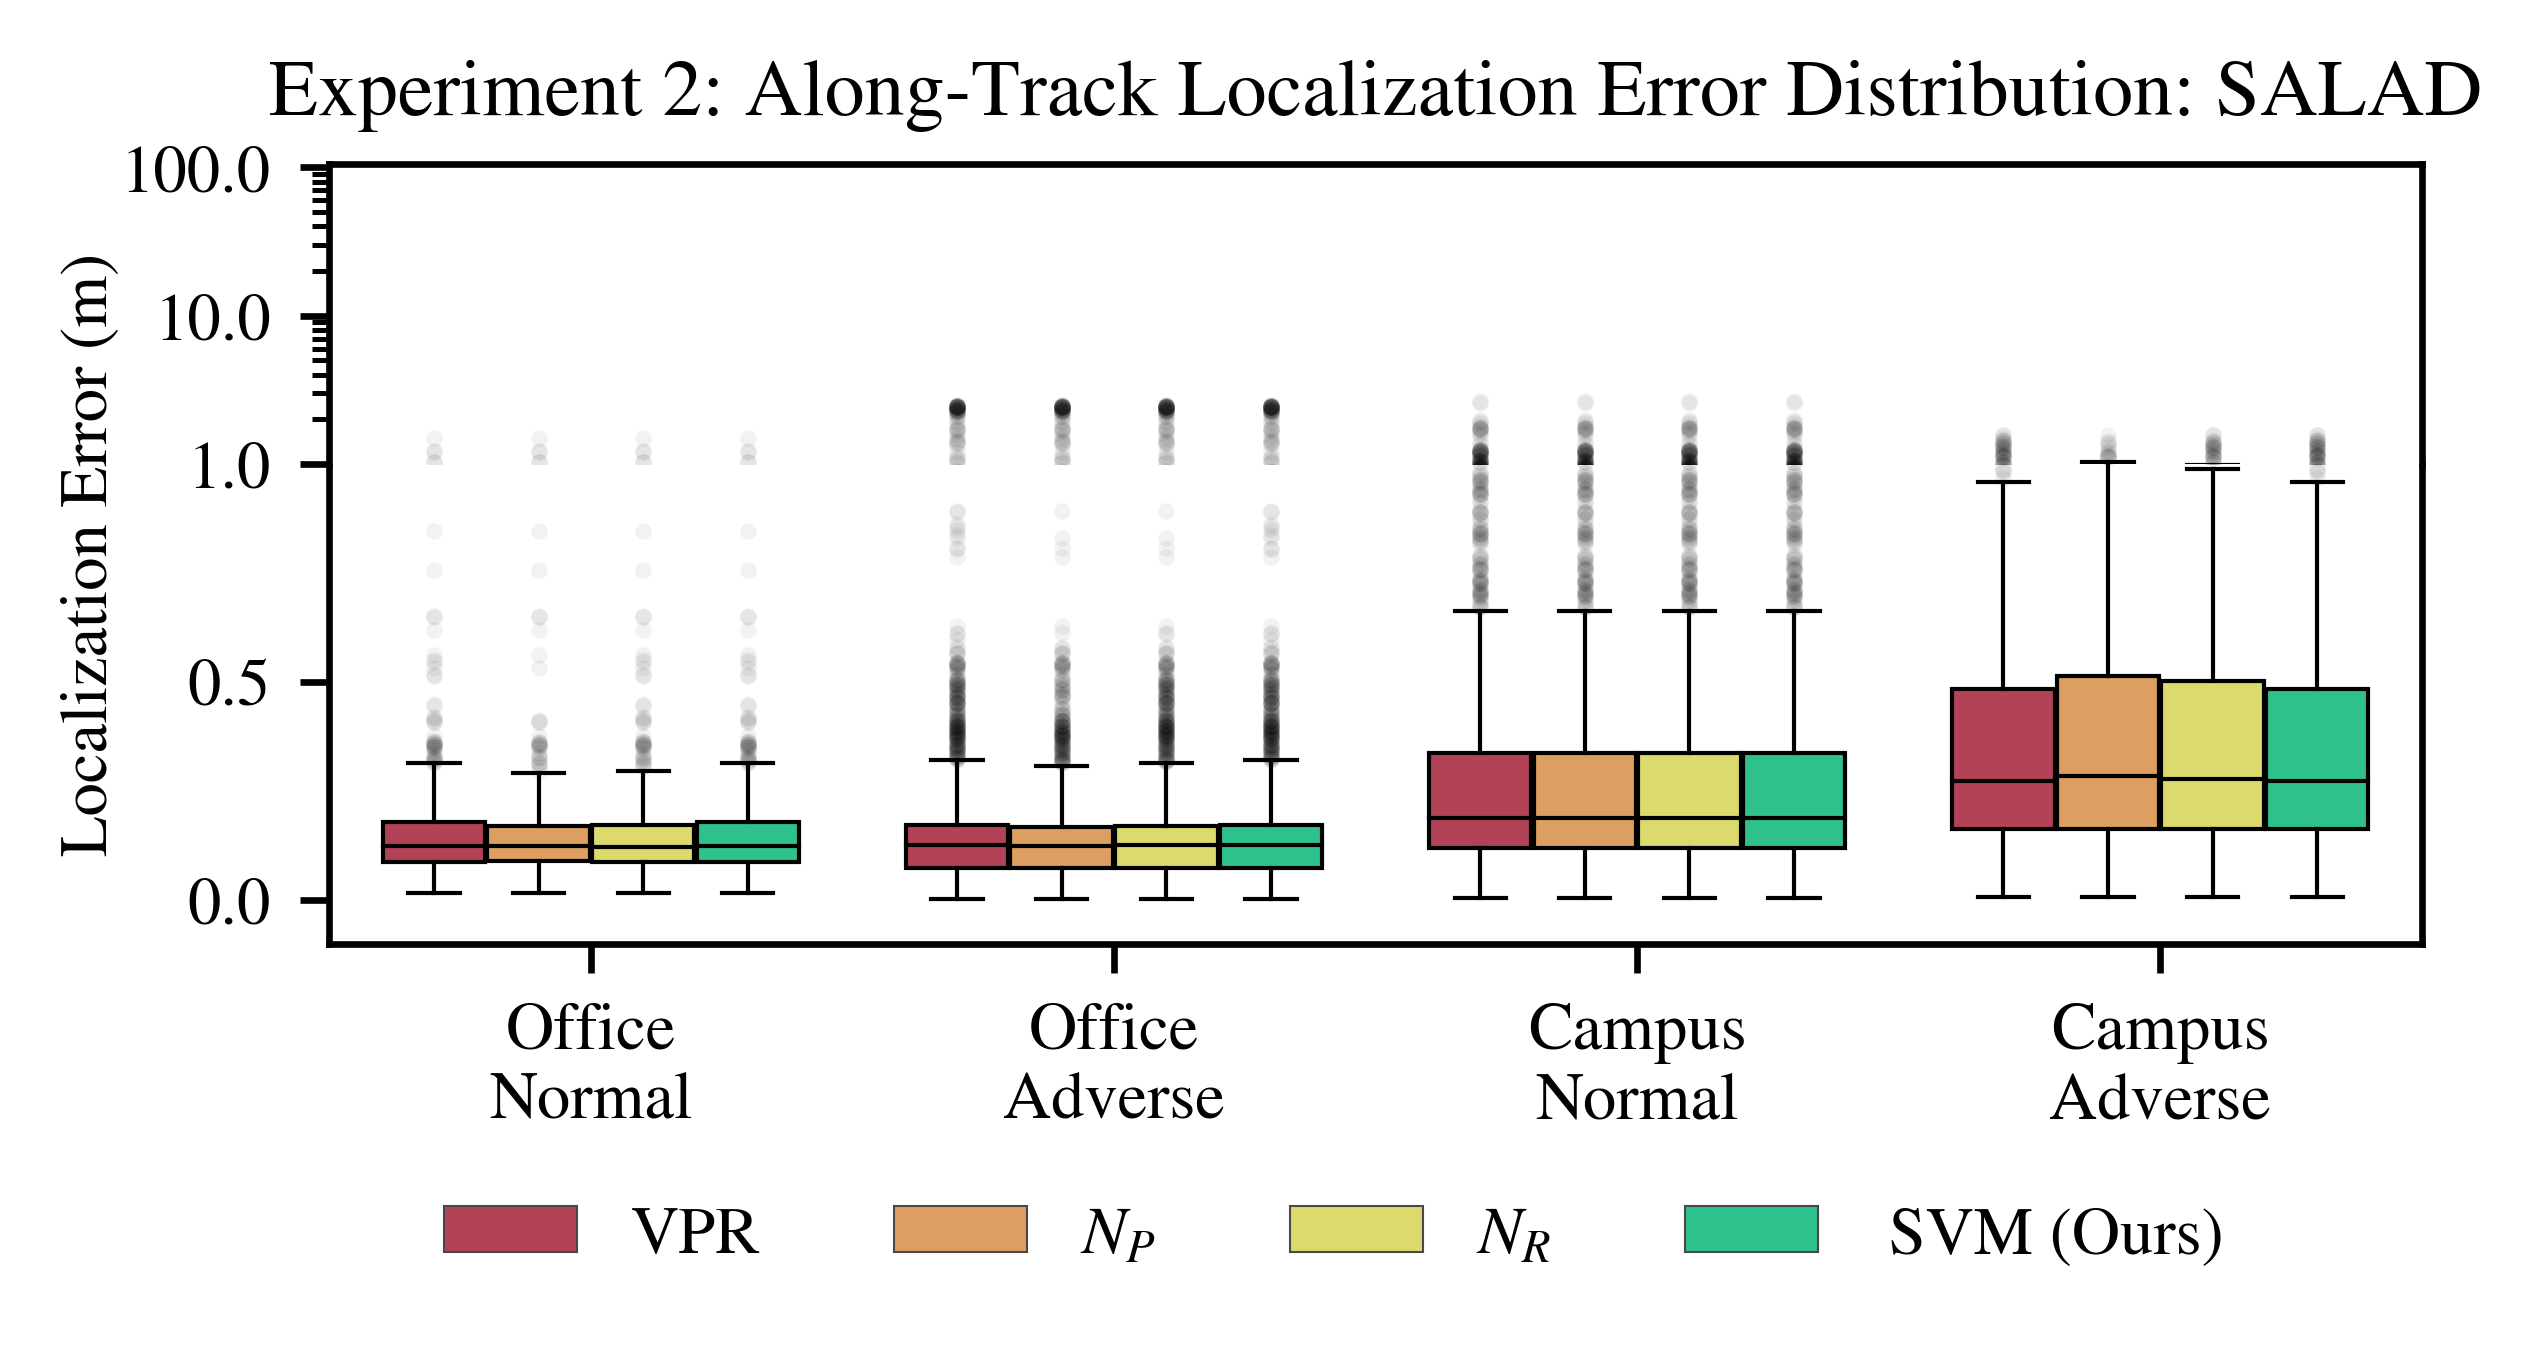

In [41]:
# For some reason, this plot breaks in Seaborn v0.13.0
# pip install seaborn==0.12.2; pgrep python | xargs kill -9
# then rerun script.

_s = 4.5/4.0

fig_22, axes_22         = plt.subplots(1,1,figsize=(4*_s,_s*1.5))

axes_22_plotter         = lambda ax: sns.boxplot(data=df[(df['slice_length']*10).astype(int).isin([15])], 
                                                 y='pos_error',x='set',hue='MODE',ax=ax, palette=_palette,
                                                 hue_order=hue_order, order=set_order, linewidth=0.5, width=0.8,
                                                 flierprops=dict(alpha=.05, marker='.', markersize=4, markeredgecolor='none', markerfacecolor='k'),
                                                 capprops=dict(color='k'),
                                                 boxprops=dict(edgecolor='k'), whiskerprops=dict(color='k'), medianprops=dict(color='k'))
axes_22log, axes_22i    = make_split_axes_y_linlog(fig_22, axes_22, [-0.1, 1, 105], axes_22_plotter, _size=0.5)

_formatter              = ticker.FormatStrFormatter("%0.1f")
axes_22log.yaxis.set_major_formatter(_formatter)

axes_22i.set_ylabel('Localization Error (m)',  labelpad=8)

axes_22log.spines['bottom'].set_visible(False) # hide red dash
axes_22log.get_legend().set_visible(False)
axes_22.get_legend().set_visible(False)

lgnd = axes_22.legend(loc='lower center', frameon=False, ncol=4, bbox_to_anchor=(0.48,-0.8))

fig_22.canvas.draw()

axes_22i.set_title('Experiment 2: Along-Track Localization Error Distribution: ' + str(ft_type.name))

path = 'media/exp2_key_results' + FF_UNIQUE_FN_EXT #relative to file directory
fig_22.savefig(path+'.pdf', format='pdf', bbox_extra_artists=(lgnd,), dpi=1000, pad_inches=0, bbox_inches='tight')
fig_22.savefig(path+'.png', format='png', bbox_extra_artists=(lgnd,), dpi=1000, pad_inches=0, bbox_inches='tight')

In [42]:
axes_22

<Axes: >

#### Generate Tables

In [43]:
df_ = df[(df['slice_length']*10).astype(int).isin([15])]
datas_names = ['vpr', 'nvp', 'nvr', 'svm']#['vpr', 'cbs', 'nvp', 'nvr', 'svm']
print(('\t\t ') + (''.join(['% 10s'%i.upper() for i in datas_names])))
for i in ['Office\nNormal', 'Office\nAdverse', 'Campus\nNormal', 'Campus\nAdverse', 'Aggregate']:
    if not (i == 'Aggregate'):
        df__ = df_[(df_['set'] == i)]
    else:
        df__ = df_

    vpr_data = df__[df__['mode']=='vpr']
    cbs_data = df__[df__['mode']=='vpr'][np.array(df__[df__['mode']=='svm']['discard']==False)]
    svm_data = df__[df__['mode']=='svm']
    nvp_data = df__[df__['mode']=='nvp']
    nvr_data = df__[df__['mode']=='nvr']

    datas = [vpr_data, nvp_data, nvr_data, svm_data]#[vpr_data, cbs_data, nvp_data, nvr_data, svm_data]
    
    print(i.replace('\n',' '))

    for _type in ['FP', 'FN']:#['TP', 'FP', 'TN', 'FN']:


        scale_  = 400 / df__.shape[0]

        type_ = np.round(np.array([scale_ * data[_type].sum() for data in datas]),2)
        type_min = list(np.where(type_ == type_.min())[0])
        type_str = ''.join([('  %6.2f%%' + ('*' if i in type_min else ' ')) % type_[i] for i in range(4)])

        
        # print(_type + ((' & %6.2f\\%%'*len(datas)) % tuple([scale_ * data[_type].sum() for data in datas])) + r' \\')
        print('\t\t ' + _type + type_str)


		        VPR       NVP       NVR       SVM
Office Normal
		 FP    0.00%*    0.00%*    0.00%*    0.00%*
		 FN    0.00%*   10.10%     3.04%     0.00%*
Office Adverse
		 FP    0.00%*    0.00%*    0.00%*    0.00%*
		 FN    0.00%*    4.34%     1.99%     0.00%*
Campus Normal
		 FP    0.12%*    0.12%*    0.12%*    0.12%*
		 FN    0.00%*    0.00%*    0.00%*    0.00%*
Campus Adverse
		 FP    0.37%     0.09%*    0.09%*    0.37% 
		 FN    0.00%*   25.90%    15.08%     0.00%*
Aggregate
		 FP    0.11%     0.06%*    0.06%*    0.11% 
		 FN    0.00%*    8.11%     4.15%     0.00%*


In [44]:
df_ = df[(df['slice_length']*10).astype(int).isin([15])]
print((' '*13) + (''.join(['% 10s'%i.upper() for i in ['vpr', 'cbs', 'nvp', 'nvr', 'svm']])))
for i in ['Office\nNormal', 'Office\nAdverse', 'Campus\nNormal', 'Campus\nAdverse', 'All']:
    if not (i == 'All'):
        df__ = df_[(df_['set'] == i)]
    else:
        df__ = df_

    vpr_data = df__[df__['mode']=='vpr']
    cbs_data = df__[df__['mode']=='vpr'][np.array(df__[df__['mode']=='svm']['discard']==False)]
    svm_data = df__[df__['mode']=='svm']
    nvp_data = df__[df__['mode']=='nvp']
    nvr_data = df__[df__['mode']=='nvr']
    
    print(i.replace('\n',' '))
    print('     Precision' + ((' & %6.2f%%'*5) % tuple([100 * (data['TP'].sum()) / ((data['TP'].sum()) + (data['FP'].sum())) for data in [vpr_data, cbs_data, nvp_data, nvr_data, svm_data]])) + r' \\')
    print('        Recall' + ((' & %6.2f%%'*5) % tuple([100 * (data['TP'].sum()) / ((data['TP'].sum()) + (data['FN'].sum())) for data in [vpr_data, cbs_data, nvp_data, nvr_data, svm_data]])) + r' \\')
    print('      Accuracy' + ((' & %6.2f%%'*5) % tuple([100 * (data['TP'].sum() + data['TN'].sum()) / len(data)              for data in [vpr_data, cbs_data, nvp_data, nvr_data, svm_data]])) + r' \\')

                    VPR       CBS       NVP       NVR       SVM
Office Normal
     Precision & 100.00% & 100.00% & 100.00% & 100.00% & 100.00% \\
        Recall & 100.00% & 100.00% &  89.90% &  96.96% & 100.00% \\
      Accuracy & 100.00% & 100.00% &  89.90% &  96.96% & 100.00% \\
Office Adverse
     Precision & 100.00% & 100.00% & 100.00% & 100.00% & 100.00% \\
        Recall & 100.00% & 100.00% &  95.66% &  98.01% & 100.00% \\
      Accuracy & 100.00% & 100.00% &  95.66% &  98.01% & 100.00% \\
Campus Normal
     Precision &  99.88% &  99.88% &  99.88% &  99.88% &  99.88% \\
        Recall & 100.00% & 100.00% & 100.00% & 100.00% & 100.00% \\
      Accuracy &  99.88% &  99.88% &  99.88% &  99.88% &  99.88% \\
Campus Adverse
     Precision &  99.63% &  99.63% &  99.87% &  99.89% &  99.63% \\
        Recall & 100.00% & 100.00% &  74.00% &  84.87% & 100.00% \\
      Accuracy &  99.63% &  99.63% &  74.01% &  84.83% &  99.63% \\
All
     Precision &  99.89% &  99.89% &  99.94% &  99.94% &  

In [45]:
df_ = df[(df['slice_length']*10).astype(int).isin([15])]
for i in ['Office\nNormal', 'Office\nAdverse', 'Campus\nNormal', 'Campus\nAdverse', 'Aggregate']:
    if not (i == 'Aggregate'):
        df__ = df_[(df_['set'] == i)]
    else:
        df__ = df_
        
    vpr_data = df__[df__['mode']=='vpr']
    cbs_data = df__[df__['mode']=='vpr'][np.array(df__[df__['mode']=='svm']['discard']==False)]
    svm_data = df__[df__['mode']=='svm']
    nvp_data = df__[df__['mode']=='nvp']
    nvr_data = df__[df__['mode']=='nvr']

    mean_vpr, conf_vpr = mean_confidence_interval(vpr_data['pos_error'].to_numpy(dtype=float))
    medi_vpr = np.nanmedian(    vpr_data['pos_error'].to_numpy(dtype=float))
    max__vpr = np.nanpercentile(vpr_data['pos_error'].to_numpy(dtype=float), [100])[0]

    mean_cbs, conf_cbs = mean_confidence_interval(cbs_data['pos_error'].to_numpy(dtype=float))
    medi_cbs = np.nanmedian(    cbs_data['pos_error'].to_numpy(dtype=float))
    max__cbs = np.nanpercentile(cbs_data['pos_error'].to_numpy(dtype=float), [100])[0]

    mean_svm, conf_svm = mean_confidence_interval(svm_data['pos_error'].to_numpy(dtype=float))
    medi_svm = np.nanmedian(    svm_data['pos_error'].to_numpy(dtype=float))
    max__svm = np.nanpercentile(svm_data['pos_error'].to_numpy(dtype=float), [100])[0]

    mean_nvp, conf_nvp = mean_confidence_interval(nvp_data['pos_error'].to_numpy(dtype=float))
    medi_nvp = np.nanmedian(    nvp_data['pos_error'].to_numpy(dtype=float))
    max__nvp = np.nanpercentile(nvp_data['pos_error'].to_numpy(dtype=float), [100])[0]

    mean_nvr, conf_nvr = mean_confidence_interval(nvr_data['pos_error'].to_numpy(dtype=float))
    medi_nvr = np.nanmedian(    nvr_data['pos_error'].to_numpy(dtype=float))
    max__nvr = np.nanpercentile(nvr_data['pos_error'].to_numpy(dtype=float), [100])[0]

    perc_gt_ = np.round(100 *   (vpr_data['pos_error']>vpr_data['tol_thres']).sum() / len(df_[(df_['set'] == i) & (df_['mode']=='vpr')]['mode']),2)

    means = np.round(np.array([mean_vpr, mean_cbs, mean_nvp, mean_nvr, mean_svm]),2)
    mean_min = list(np.where(means == means.min())[0])
    mean_str = ''.join([('  %6.2fm' + ('*' if i in mean_min else ' ')) % means[i] for i in range(5)])

    medis = np.round(np.array([medi_vpr, medi_cbs, medi_nvp, medi_nvr, medi_svm]),2)
    medi_min = list(np.where(medis == medis.min())[0])
    medi_str = ''.join([('  %6.2fm' + ('*' if i in medi_min else ' ')) % medis[i] for i in range(5)])

    max_s = np.round(np.array([max__vpr, max__cbs, max__nvp, max__nvr, max__svm]),2)
    max__min = list(np.where(max_s == max_s.min())[0])
    max__str = ''.join([('  %6.2fm' + ('*' if i in max__min else ' ')) % max_s[i] for i in range(5)])

    print('% 33s' % i.replace('\n',' '))
    print((' '*6) + ''.join(['% 10s' % i for i in ['VPR', 'CBS', 'NVP', 'NVR', 'SVM']]))
    LATEX_MODE=True
    if LATEX_MODE:
        print('& Mean', '& %6.2fm' % mean_vpr, '& %6.2fm' % mean_cbs, '& %6.2fm' % mean_nvp, '& %6.2fm' % mean_nvr, '& %6.2fm' % mean_svm, r'\\')
        print('& Med.', '& %6.2fm' % medi_vpr, '& %6.2fm' % medi_cbs, '& %6.2fm' % medi_nvp, '& %6.2fm' % medi_nvr, '& %6.2fm' % medi_svm, r'\\')
        print('& Max.', '& %6.2fm' % max__vpr, '& %6.2fm' % max__cbs, '& %6.2fm' % max__nvp, '& %6.2fm' % max__nvr, '& %6.2fm' % max__svm, r'\\')
    else:
        print('  Mean ' + mean_str)
        print('  Med. ' + medi_str)
        print('  Max. ' + max__str)
    print('')

                    Office Normal
             VPR       CBS       NVP       NVR       SVM
& Mean &   0.15m &   0.15m &   0.15m &   0.15m &   0.15m \\
& Med. &   0.12m &   0.12m &   0.12m &   0.12m &   0.12m \\
& Max. &   1.51m &   1.51m &   1.51m &   1.51m &   1.51m \\

                   Office Adverse
             VPR       CBS       NVP       NVR       SVM
& Mean &   0.20m &   0.20m &   0.20m &   0.20m &   0.20m \\
& Med. &   0.13m &   0.13m &   0.12m &   0.13m &   0.13m \\
& Max. &   2.52m &   2.52m &   2.52m &   2.52m &   2.52m \\



                    Campus Normal
             VPR       CBS       NVP       NVR       SVM
& Mean &   0.28m &   0.28m &   0.28m &   0.28m &   0.28m \\
& Med. &   0.19m &   0.19m &   0.19m &   0.19m &   0.19m \\
& Max. &   2.66m &   2.66m &   2.66m &   2.66m &   2.66m \\

                   Campus Adverse
             VPR       CBS       NVP       NVR       SVM
& Mean &   0.35m &   0.35m &   0.36m &   0.36m &   0.35m \\
& Med. &   0.27m &   0.27m &   0.28m &   0.28m &   0.27m \\
& Max. &   1.56m &   1.56m &   1.56m &   1.56m &   1.56m \\

                        Aggregate
             VPR       CBS       NVP       NVR       SVM
& Mean &   0.25m &   0.25m &   0.24m &   0.25m &   0.25m \\
& Med. &   0.16m &   0.16m &   0.15m &   0.15m &   0.16m \\
& Max. &   2.66m &   2.66m &   2.66m &   2.66m &   2.66m \\



#### Single Case Examples

In [46]:
ln_ref_dict        = dict( bag_name=bags['Office']['Normal']['ref'], npz_dbp=npz_dbp, bag_dbp=bag_dbp, \
                        odom_topic=odom_topic, img_topics=img_topics, sample_rate=sample_rate, \
                        ft_types=[enum_name(ft_type)], img_dims=img_dims, filters=ref_filter)
cn_ref_dict        = dict( bag_name=bags['Campus']['Normal']['ref'], npz_dbp=npz_dbp, bag_dbp=bag_dbp, \
                        odom_topic=odom_topic, img_topics=img_topics, sample_rate=sample_rate, \
                        ft_types=[enum_name(ft_type)], img_dims=img_dims, filters=ref_filter)
la_ref_dict        = dict( bag_name=bags['Office']['Adverse']['ref'], npz_dbp=npz_dbp, bag_dbp=bag_dbp, \
                        odom_topic=odom_topic, img_topics=img_topics, sample_rate=sample_rate, \
                        ft_types=[enum_name(ft_type)], img_dims=img_dims, filters=ref_filter)
ca_ref_dict        = dict( bag_name=bags['Campus']['Adverse']['ref'], npz_dbp=npz_dbp, bag_dbp=bag_dbp, \
                        odom_topic=odom_topic, img_topics=img_topics, sample_rate=sample_rate, \
                        ft_types=[enum_name(ft_type)], img_dims=img_dims, filters=ref_filter)
ln_ref_ip          = VPRDatasetProcessor(None, try_gen=True, cuda=True, autosave=True, ros=False, init_netvlad=True, **kwargs_ip)
cn_ref_ip          = VPRDatasetProcessor(None, try_gen=True, cuda=True, autosave=True, ros=False, init_netvlad=True, **kwargs_ip)
la_ref_ip          = VPRDatasetProcessor(None, try_gen=True, cuda=True, autosave=True, ros=False, init_netvlad=True, **kwargs_ip)
ca_ref_ip          = VPRDatasetProcessor(None, try_gen=True, cuda=True, autosave=True, ros=False, init_netvlad=True, **kwargs_ip)
ln_ref_ip.pass_nns(ip, pass_nn_args)
ln_ref_ip.load_dataset(ln_ref_dict, True)
cn_ref_ip.pass_nns(ip, pass_nn_args)
cn_ref_ip.load_dataset(cn_ref_dict, True)
la_ref_ip.pass_nns(ip, pass_nn_args)
la_ref_ip.load_dataset(la_ref_dict, True)
ca_ref_ip.pass_nns(ip, pass_nn_args)
ca_ref_ip.load_dataset(ca_ref_dict, True)

[INFO] [VPRDatasetProcessor] Ready; no dataset loaded.
[INFO] [VPRDatasetProcessor] Ready; no dataset loaded.
[INFO] [VPRDatasetProcessor] Ready; no dataset loaded.
[INFO] [VPRDatasetProcessor] Ready; no dataset loaded.
[INFO] [VPRDatasetProcessor] => Trying to load checkpoint '/home/claxton/aarapsi_offrobot_ws/src/aarapsi_robot_pack/src/pyaarapsi/vpr_classes/downloads//mapillary_WPCA4096.pth.tar'
[INFO] [VPRDatasetProcessor] => Successfully loaded checkpoint '/home/claxton/aarapsi_offrobot_ws/src/aarapsi_robot_pack/src/pyaarapsi/vpr_classes/downloads//mapillary_WPCA4096.pth.tar'
[INFO] [VPRDatasetProcessor] Loading HybridNet model
[INFO] [VPRDatasetProcessor] HybridNet loaded
[INFO] [VPRDatasetProcessor] [load_dataset] Loading dataset.
[INFO] [VPRDatasetProcessor] [load_dataset] Loading dataset.
[INFO] [VPRDatasetProcessor] [load_dataset] Loading dataset.
[INFO] [VPRDatasetProcessor] [load_dataset] Loading dataset.


'dataset_20240201_12'

In [47]:
if 0:
    _s = 5.0/4.0
    fig_5, axes_5 = plt.subplots(2,2,figsize=(4*_s,1.5*_s))

    _step = 2
    _shared_style = dict(marker='.', linestyle='none', alpha=0.5, markersize=10, markeredgecolor='k', markeredgewidth=0.2)
    lines_style = dict(linewidths=0.6)

    _qd_hash = {'Office\nNormal': qd_ln, 'Office\nAdverse': qd_la, 'Campus\nNormal': qd_cn, 'Campus\nAdverse': qd_ca}
    _ip_hash = {'Office\nNormal': ln_ref_ip.dataset['dataset'], 'Office\nAdverse': la_ref_ip.dataset['dataset'], 'Campus\nNormal': cn_ref_ip.dataset['dataset'], 'Campus\nAdverse': ca_ref_ip.dataset['dataset']}

    bgimg1 = matplotlib.image.imread('media/outdoors_2a.jpg')
    bgimg2 = matplotlib.image.imread('media/carpet_2.jpg')

    _env    = 'Campus'
    _cond   = 'Normal'
    _set    = _env+'\n'+_cond
    _qd     = _qd_hash[_set]
    _ip     = _ip_hash[_set]

    wo_sum, wo_len = calc_path_stats(_qd['wo_xyw'][:,0:2])
    dd_ind_min     = np.argmin(abs(np.array(wo_sum) - 1.5)) + 1
    dd_ind_max     = len(_qd['wo_xyw'])

    _min    = 1600
    _max    = np.min([_min + 28, dd_ind_max-dd_ind_min])
    _slice  = slice(_min,_max, _step)
    dd      = slice(dd_ind_min, dd_ind_max+1)

    _os       = _qd['gt_xyw'][dd][_slice][0]
    gt_xyw    = _qd['gt_xyw'][dd][_slice] - _os
    xyw_vpr   = np.array([[_ip['p'+j][i] for j in 'xyw'] for i in df[(df['mode']=='vpr') & (df['set']==_set)]['lInd']])[_slice] - _os
    xyw_svm   = np.array([[_ip['p'+j][i] for j in 'xyw'] if not np.isnan(i) else [np.nan]*3 for i in df[(df['mode']=='svm') & (df['set']==_set)]['lInd']])[_slice] - _os
    lines_vpr = [[(gt_xyw[i,0], gt_xyw[i,1]), (xyw_vpr[i,0],xyw_vpr[i,1])] for i in range(len(gt_xyw))]
    lines_svm = [[(gt_xyw[i,0], gt_xyw[i,1]), (xyw_svm[i,0],xyw_svm[i,1])] for i in range(len(gt_xyw))]

    axes_5[0][0].plot(gt_xyw[:,0],   gt_xyw[:,1],   markerfacecolor='y', **_shared_style)
    axes_5[0][0].plot(xyw_vpr[:,0],  xyw_vpr[:,1],  markerfacecolor='b', **_shared_style)
    axes_5[0][0].add_collection(matplotlib.collections.LineCollection(lines_vpr, **lines_style, colors=('r','r','k','k','k','k','k','k','k','k','k','k','k','k','k')))

    axes_5[1][0].plot(gt_xyw[:,0],   gt_xyw[:,1],   markerfacecolor='y', **_shared_style, label='True Position')
    axes_5[1][0].plot(xyw_svm[:,0],  xyw_svm[:,1],  markerfacecolor='b', **_shared_style, label='Match Position')
    axes_5[1][0].add_collection(matplotlib.collections.LineCollection(lines_svm, **lines_style, colors=('r','r','k','k','k','k','k','k','k','k','k','k','k','k','k')))

    _env    = 'Office'
    _cond   = 'Normal'
    _set    = _env+'\n'+_cond
    _qd     = _qd_hash[_set]
    _ip     = _ip_hash[_set]

    wo_sum, wo_len = calc_path_stats(_qd['wo_xyw'][:,0:2])
    dd_ind_min     = np.argmin(abs(np.array(wo_sum) - 1.5)) + 1
    dd_ind_max     = len(_qd['wo_xyw'])

    _min    = 640
    _max    = np.min([_min + 28, dd_ind_max-dd_ind_min])
    _slice  = slice(_min,_max, _step)
    dd      = slice(dd_ind_min, dd_ind_max+1)


    tb = Transform_Builder()
    _H = tb.rotate(0,0,-5,radians=False).translate(0.3,0,0).get()

    _os         = _qd['gt_xyw'][dd][_slice][0]
    gt_xyw_R    = _qd['gt_xyw'][dd][_slice] - _os
    xyw_vpr_R   = np.array([[_ip['p'+j][i] for j in 'xyw'] for i in df[(df['mode']=='vpr') & (df['set']==_set)]['lInd']])[_slice] - _os
    xyw_svm_R   = np.array([[_ip['p'+j][i] for j in 'xyw'] if not np.isnan(i) else [np.nan]*3 for i in df[(df['mode']=='svm') & (df['set']==_set)]['lInd']])[_slice] - _os
    gt_x, gt_y, _   = apply_homogeneous_transform(_H, gt_xyw_R[:,0], gt_xyw_R[:,1])
    vpr_x, vpr_y, _ = apply_homogeneous_transform(_H, xyw_vpr_R[:,0], xyw_vpr_R[:,1])
    svm_x, svm_y, _ = apply_homogeneous_transform(_H, xyw_svm_R[:,0], xyw_svm_R[:,1])
    gt_xyw          = np.transpose(np.array([gt_x, gt_y]))
    xyw_vpr         = np.transpose(np.array([vpr_x, vpr_y]))
    xyw_svm         = np.transpose(np.array([svm_x, svm_y]))

    lines_vpr = [[(gt_xyw[i,0], gt_xyw[i,1]), (xyw_vpr[i,0],xyw_vpr[i,1])] for i in range(len(gt_xyw))]
    lines_svm = [[(gt_xyw[i,0], gt_xyw[i,1]), (xyw_svm[i,0],xyw_svm[i,1])] for i in range(len(gt_xyw))]

    axes_5[0][1].plot(gt_xyw[:,0],   gt_xyw[:,1],   markerfacecolor='y', **_shared_style)
    axes_5[0][1].plot(xyw_vpr[:,0],  xyw_vpr[:,1],  markerfacecolor='b', **_shared_style)
    axes_5[0][1].add_collection(matplotlib.collections.LineCollection(lines_vpr, **lines_style, colors=('k','k','k','k','r','r','k','k','k','k','k','k','k')))

    axes_5[1][1].plot(gt_xyw[:,0],   gt_xyw[:,1],   markerfacecolor='y', **_shared_style, label='True Position')
    axes_5[1][1].plot(xyw_svm[:,0],  xyw_svm[:,1],  markerfacecolor='b', **_shared_style, label='Match Position')
    axes_5[1][1].add_collection(matplotlib.collections.LineCollection(lines_svm, **lines_style, colors=('k','k','k','k','r','r','k','k','k','k','k','k','k')))

    for i in [0,1]:
        for j in [0,1]:
            axes_5[i][j].grid('on')
            axes_5[i][j].tick_params(axis='both', which='both', direction='in', labelleft=False, labelbottom=False, right=True, top=True, length=2, width=0.66, grid_linewidth=0.2, grid_color='none', grid_alpha=0.8)

    axes_5[0][0].set_ylabel('Baseline\nVPR')
    axes_5[1][0].set_ylabel('SVM\n(Ours)')
    axes_5[0][0].set_title('Removed Estimates')
    axes_5[0][1].set_title('Improved Estimates')
    fig_5.subplots_adjust(hspace=0, wspace=0.1)

    axes_5i = fig_5.add_subplot(111, frameon=False)
    axes_5i.tick_params(axis='both', which='both', labelleft=False, labelbottom=False, left=False, bottom=False)
    axes_5i.set_xlabel(r'Grid: {x: 20cm, y: 10cm}')

    _arrow = dict(width=0.02, head_width=0.07, length_includes_head=True, overhang=0, color='r')

    y1=0.03
    y2=0.02
    axes_5[0][0].arrow(             x=0.000, y= 0.110-y1, dx=0, dy=-0.050, head_length=0.025, **_arrow, label='Changed')
    axes_5[0][0].arrow(             x=0.200, y= 0.118-y1, dx=0, dy=-0.050, head_length=0.025, **_arrow, label='Changed')
    axes_5[1][0].arrow(             x=0.000, y= 0.110-y1, dx=0, dy=-0.050, head_length=0.025, **_arrow, label='Changed')
    axes_5[1][0].arrow(             x=0.200, y= 0.118-y1, dx=0, dy=-0.050, head_length=0.025, **_arrow, label='Changed')

    axes_5[0][1].arrow(             x=0.875, y= 0.032-y2, dx=0, dy=-0.055, head_length=0.028, **_arrow, label='Changed')
    axes_5[0][1].arrow(             x=1.013, y= 0.024-y2, dx=0, dy=-0.055, head_length=0.028, **_arrow, label='Changed')
    axes_5[1][1].arrow(             x=0.875, y= 0.032-y2, dx=0, dy=-0.055, head_length=0.028, **_arrow, label='Changed')
    plt_arrow = axes_5[1][1].arrow( x=1.013, y= 0.024-y2, dx=0, dy=-0.055, head_length=0.028, **_arrow, label='Changed')


    legend_elements = [ Line2D([0], [0], marker='.', label='Match Position', color='k',  linewidth=0, markersize=10, markerfacecolor='b', markeredgewidth=0.3),
                        Line2D([0], [0], marker='.', label='True Position',  color='k',  linewidth=0, markersize=10, markerfacecolor='y', markeredgewidth=0.3),
                        plt_arrow,
                    ]
    lgnd = axes_5[1][0].legend(handles=legend_elements, loc='lower center', ncol=3, columnspacing=0.4, handletextpad=-0.3, frameon=False, bbox_to_anchor=(1.05,-0.6), handler_map={matplotlib.patches.FancyArrow : matplotlib.legend_handler.HandlerPatch(patch_func=make_legend_arrow),
                        })

    axes_5[0][0].imshow(bgimg1[20:,:], extent=[-0.1, 3, -0.05, 0.20], alpha=0.5)
    axes_5[0][0].set_aspect('auto')
    axes_5[1][0].imshow(bgimg1[20:,:], extent=[-0.1, 3, -0.05, 0.20], alpha=0.5)
    axes_5[1][0].set_aspect('auto')

    axes_5[0][1].imshow(bgimg2[:,:], extent=[-0.1, 3, -0.20, 0.10], alpha=0.5)
    axes_5[0][1].set_aspect('auto')
    axes_5[1][1].imshow(bgimg2[:,:], extent=[-0.1, 3, -0.20, 0.10], alpha=0.5)
    axes_5[1][1].set_aspect('auto')

    axes_5[0][0].set_xticks(np.arange(0,3,0.2))
    axes_5[1][0].set_xticks(np.arange(0,3,0.2))
    axes_5[0][1].set_xticks(np.arange(0,3,0.2))
    axes_5[1][1].set_xticks(np.arange(0,3,0.2))

    axes_5[0][0].set_yticks(np.arange(-0.15,0.35,0.1))
    axes_5[1][0].set_yticks(np.arange(-0.15,0.35,0.1))
    axes_5[0][1].set_yticks(np.arange(-0.25,0.25,0.1))
    axes_5[1][1].set_yticks(np.arange(-0.25,0.25,0.1))

    axes_5[0][0].set_ylim(-0.05,0.20)
    axes_5[1][0].set_ylim(-0.05,0.20)
    axes_5[0][1].set_ylim(-0.20,0.10)
    axes_5[1][1].set_ylim(-0.20,0.10)

    plt.show()


    path = 'media/exp2_along_path_example' + FF_UNIQUE_FN_EXT #relative to file directory
    fig_5.savefig(path+'.pdf', format='pdf', bbox_extra_artists=(lgnd,), dpi=1000, pad_inches=0, bbox_inches='tight')
    fig_5.savefig(path+'.png', format='png', bbox_extra_artists=(lgnd,), dpi=1000, pad_inches=0, bbox_inches='tight')

# All feature types

## Data

In [48]:
_df_features = {}
for _ft_type in [FeatureType.RAW, FeatureType.NETVLAD, FeatureType.SALAD]:
    _fsorted      = getfactors(_ft_type)
    file_name     = 'pickle_data/' + "experiment_2_data" + make_ff_unique_fn_ext(feature_type=_ft_type) + ".obj"

    with (open(file_name, "rb")) as openfile:
        DATA_CONTAINER = pickle.load(openfile)

    _df = DATA_CONTAINER['df']
    _df['vprfeaturetype'] = _ft_type.name
    _df['svmfactor1type'] = _fsorted[0]
    _df['svmfactor2type'] = _fsorted[1]

    _df_features[_ft_type.name] = _df

df_features = pd.concat([_df_features[i] for i in _df_features.keys()])

## Plots

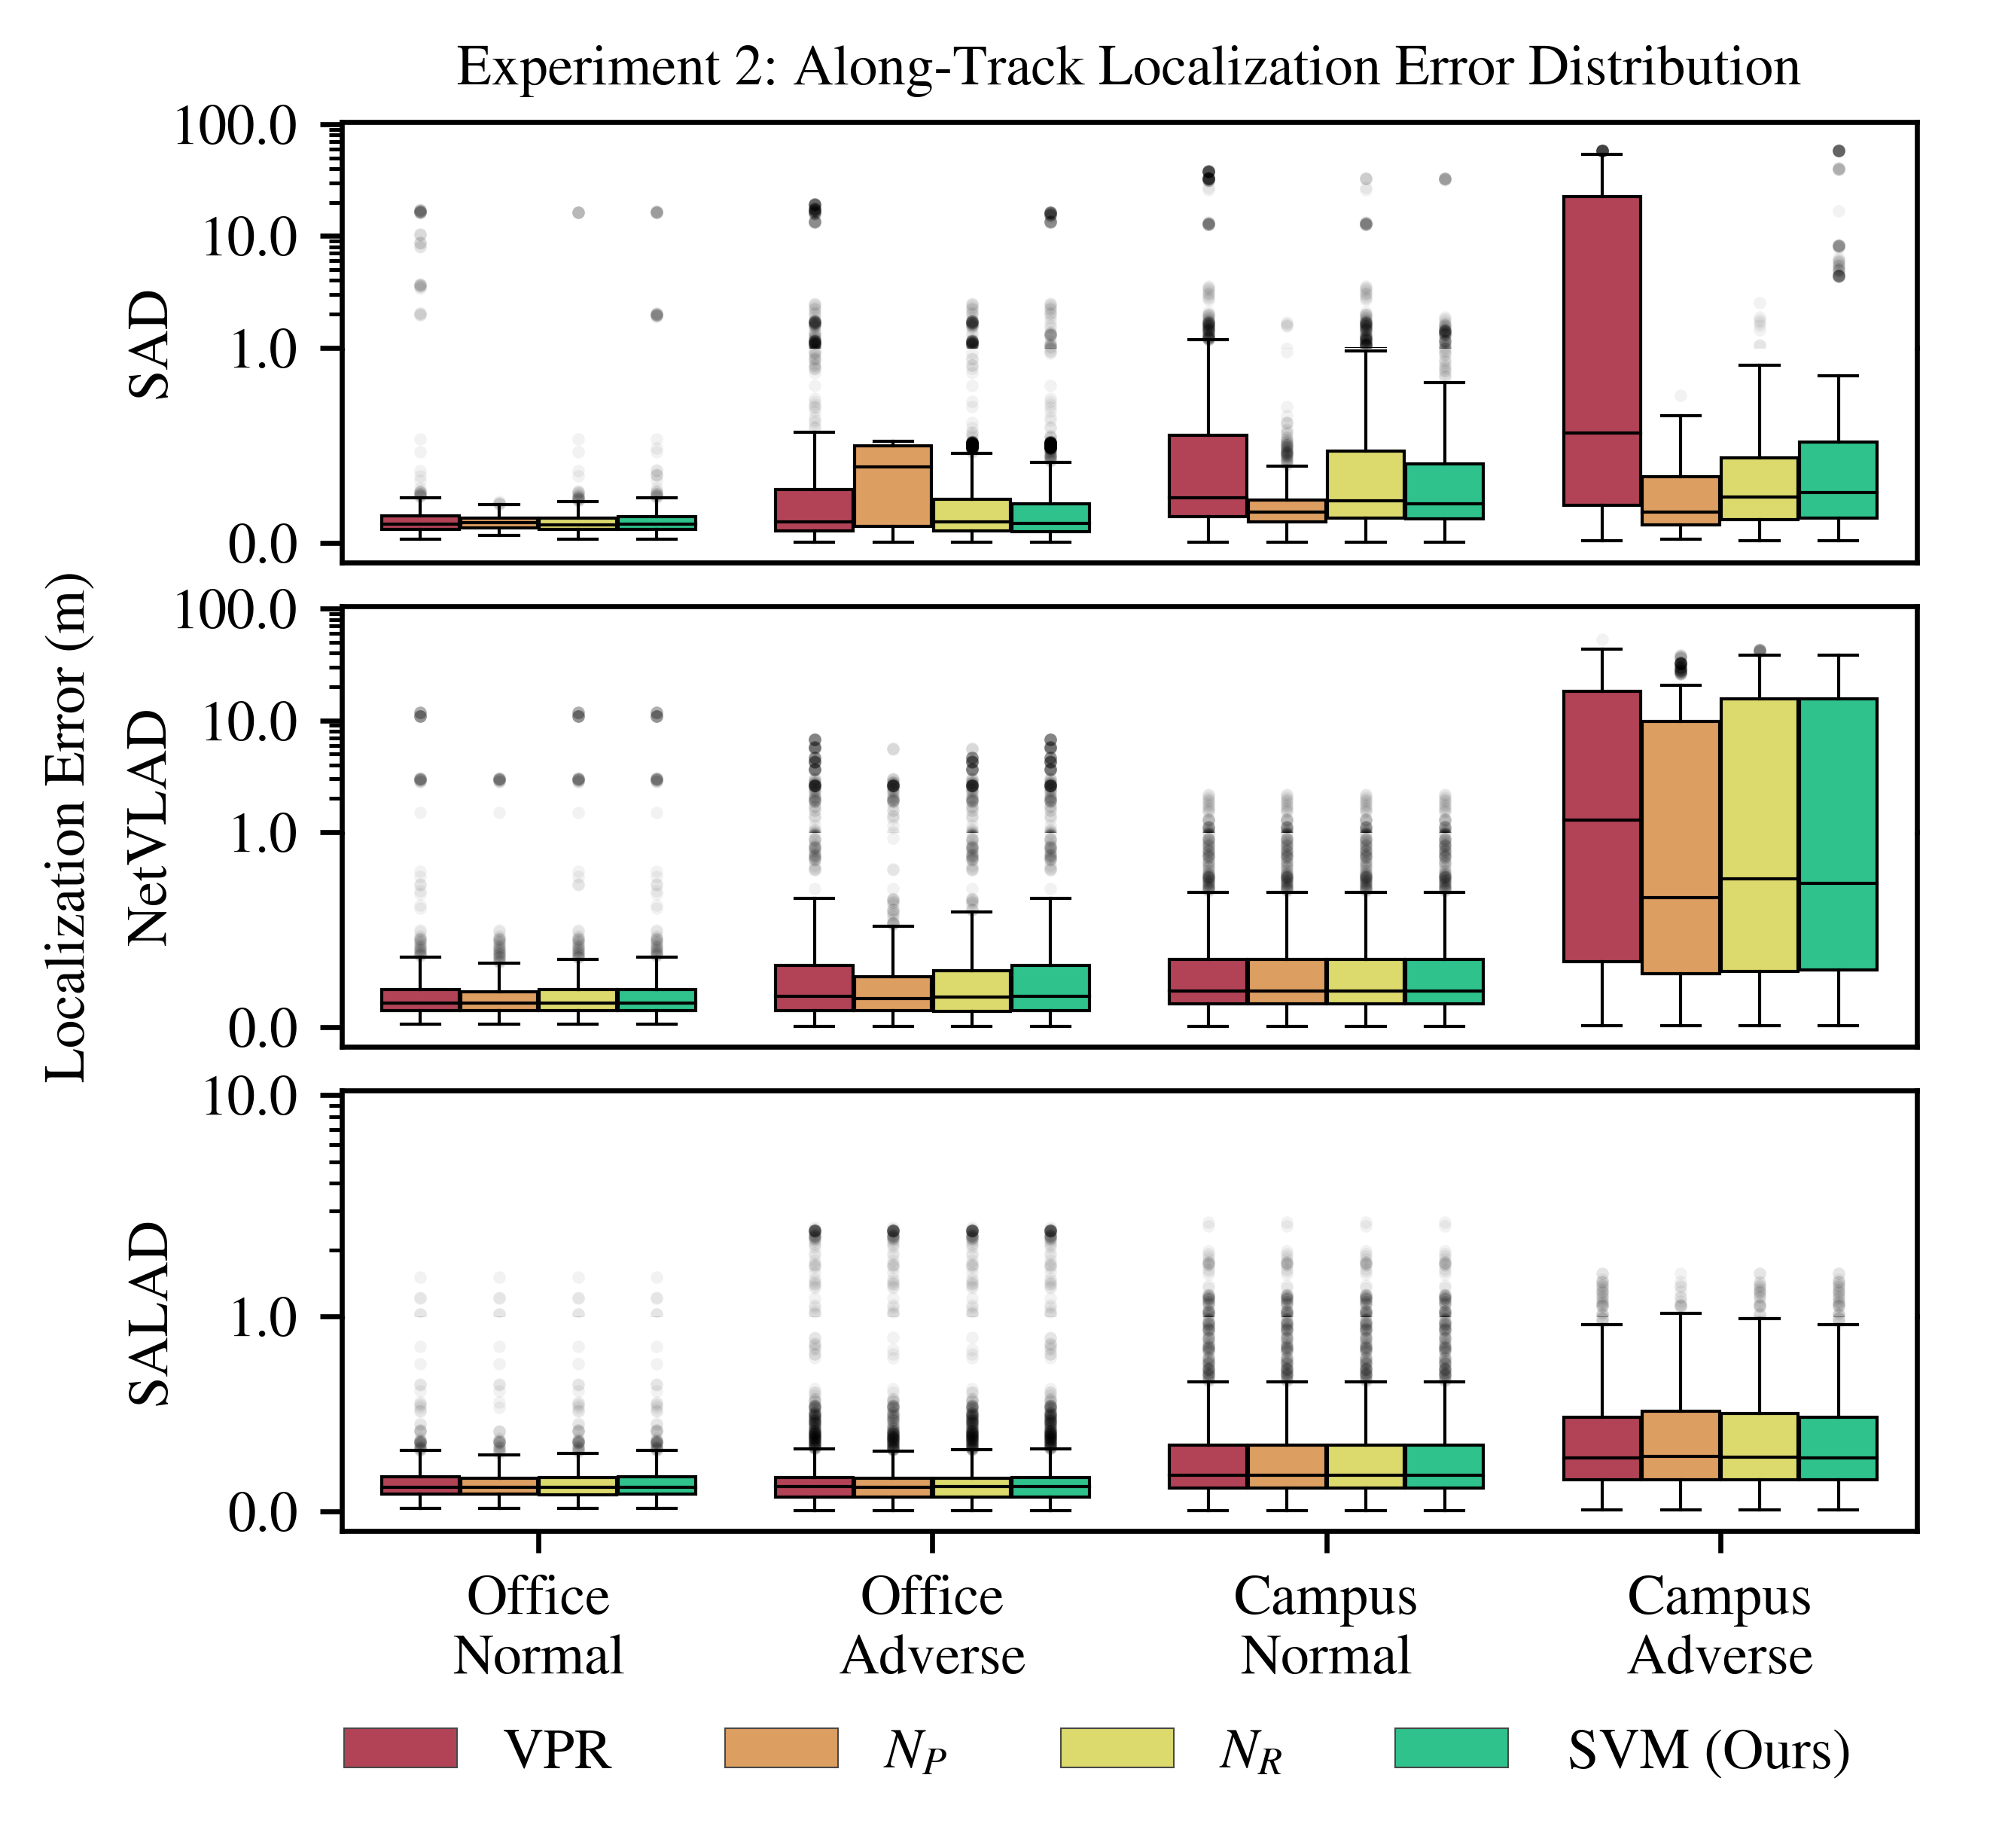

In [49]:
if True:
    # For some reason, this plot breaks in Seaborn v0.13.0
    # pip install seaborn==0.12.2; pgrep python | xargs kill -9
    # then rerun script.

    def adj_make_split_axes_y_linlog(_fig, _axes, _lims, _plotter, _logplotter=None, _subplot=111, _size=1):
        # Configure base axis as linear:
        _axes.set_yscale('linear')
        _axes.set_ylim((_lims[0], _lims[1]))

        # Generate, attach, and configure a secondary logarithmic axis:
        _axes_divider = make_axes_locatable(_axes)
        _axeslog = _axes_divider.append_axes("top", size=_size, pad=0, sharex=_axes)
        _axeslog.set_yscale('log')
        _axeslog.set_ylim((_lims[1]+0.001*_lims[1], _lims[2])) # add a miniscule amount to the start to prevent duplicated axis labels

        # Plot the data in both axes:
        _plotter(_axes)
        _plotter(_axeslog)

        # Hide middle bar:
        _axes.spines['top'].set_visible(False)
        _axeslog.spines['bottom'].set_visible(False)
        _axeslog.xaxis.set_visible(False)

        # Create an invisible frame to provide overarching anchor positions for axis labels:
        _axes.set_ylabel('')
        _axes.set_xlabel('')
        _axeslog.set_ylabel('')
        _axeslog.set_xlabel('')

        _axeslog.get_legend().set_visible(False)
        _axes.get_legend().set_visible(False)

        return _axeslog

    _s = 4.5/4.0

    fig_m1, axes_m1         = plt.subplots(3,1,figsize=(4*_s,_s*1.2*3), sharex=True)

    axes_m1_plotter         = lambda ft_type, ax: sns.boxplot(data=df_features[(df_features['vprfeaturetype']==ft_type) & (df_features['slice_length']*10).astype(int).isin([15])], 
                                                    y='pos_error',x='set',hue='MODE',ax=ax, palette=_palette,
                                                    hue_order=hue_order, order=set_order, linewidth=0.5, width=0.8,
                                                    flierprops=dict(alpha=.05, marker='.', markersize=4, markeredgecolor='none', markerfacecolor='k'),
                                                    capprops=dict(color='k'),
                                                    boxprops=dict(edgecolor='k'), whiskerprops=dict(color='k'), medianprops=dict(color='k'))
    axes_m1log0             = adj_make_split_axes_y_linlog(fig_m1, axes_m1[0], [-0.1, 1, 105], lambda ax: axes_m1_plotter('RAW', ax), _size=0.5)
    axes_m1log1             = adj_make_split_axes_y_linlog(fig_m1, axes_m1[1], [-0.1, 1, 105], lambda ax: axes_m1_plotter('NETVLAD', ax), _size=0.5)
    axes_m1log2             = adj_make_split_axes_y_linlog(fig_m1, axes_m1[2], [-0.1, 1, 10.5], lambda ax: axes_m1_plotter('SALAD', ax), _size=0.5)
    # axes_m1_plotter('SALAD', axes_m1[2])
    # axes_m1[2].set_ylabel('')
    # axes_m1[2].set_xlabel('')
    # axes_m1[2].get_legend().set_visible(False)

    _formatter              = ticker.FormatStrFormatter("%0.1f")
    axes_m1[0].yaxis.set_major_formatter(_formatter)
    axes_m1[1].yaxis.set_major_formatter(_formatter)
    axes_m1[2].yaxis.set_major_formatter(_formatter)
    axes_m1log0.yaxis.set_major_formatter(_formatter)
    axes_m1log1.yaxis.set_major_formatter(_formatter)
    axes_m1log2.yaxis.set_major_formatter(_formatter)

    axes_m1[0].tick_params(bottom=False)
    axes_m1[1].tick_params(bottom=False)

    # axes_m1log0.set_title('Feature Type: SAD', fontsize=7)
    # axes_m1log1.set_title('Feature Type: NETVLAD', fontsize=7)
    # axes_m1log2.set_title('Feature Type: SALAD', fontsize=7)
    # # axes_m1[2].set_title('Feature Type: SALAD', fontsize=7)axes_m1log0.set_title('Feature Type: SAD', fontsize=7)

    small_frame0 = fig_m1.add_subplot(311, frameon=False)
    small_frame1 = fig_m1.add_subplot(312, frameon=False)
    small_frame2 = fig_m1.add_subplot(313, frameon=False)

    small_frame0.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    small_frame1.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    small_frame2.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    small_frame0.set_ylabel('SAD',      fontsize=9, labelpad=5)
    small_frame1.set_ylabel('NetVLAD',  fontsize=9, labelpad=5)
    small_frame2.set_ylabel('SALAD',    fontsize=9, labelpad=5)
    # axes_m1[2].set_title('Feature Type: SALAD', fontsize=7)axes_m1log0.set_title('Feature Type: SAD', fontsize=7)

    big_frame = fig_m1.add_subplot(111, frameon=False)
    big_frame.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_frame.set_ylabel('Localization Error (m)',  labelpad=22, fontsize=9)
    big_frame.set_title('Experiment 2: Along-Track Localization Error Distribution', fontsize=9)

    lgnd = axes_m1[2].legend(loc='lower center', frameon=False, ncol=4, bbox_to_anchor=(0.48,-1.4), fontsize=9)

    axes_m1[0].tick_params(axis='both', which='both', labelsize=9)
    axes_m1[1].tick_params(axis='both', which='both', labelsize=9)
    axes_m1[2].tick_params(axis='both', which='both', labelsize=9)
    axes_m1log0.tick_params(axis='both', which='both', labelsize=9)
    axes_m1log1.tick_params(axis='both', which='both', labelsize=9)
    axes_m1log2.tick_params(axis='both', which='both', labelsize=9)

    fig_m1.subplots_adjust(hspace=0.1)

    fig_m1.canvas.draw()


    path = 'media/exp2_extended_key_results_vertical' #relative to file directory
    fig_m1.savefig(path+'.pdf', format='pdf', bbox_extra_artists=(lgnd,), dpi=1000, pad_inches=0, bbox_inches='tight')
    fig_m1.savefig(path+'.png', format='png', bbox_extra_artists=(lgnd,), dpi=1000, pad_inches=0, bbox_inches='tight')

## Tables

In [50]:
if True:
    LATEX_MODE = True

    if LATEX_MODE:
        _sb = r'\B{'
        _sn = r''
        _eb = r'm}'
        _en = r'm '
        _ee = r' \\'
        _sf = '& % 10s '
    else:
        _sb = r'  '
        _sn = r''
        _eb = r'm*'
        _en = r'm '
        _ee = r'   '
        _sf = ' % 10s |'
    print()
    df_ = df_features[(df_features['slice_length']*10).astype(int).isin([15])]
    for featname, feat in zip(['SAD', 'NetVLAD', 'SALAD'], ['RAW', 'NETVLAD', 'SALAD']):
        
        if LATEX_MODE:
            if feat != 'RAW':
                print(r'    \hline')
            else:
                print(r'    \cline{3-7}')
            print(r'    & & \multicolumn{5}{c|}{\B{' + featname + r' Features}} \\')
            if feat == 'RAW':
                print(r'    & & \B{Baseline} & \B{BL++ } & \multicolumn{3}{c|}{\B{Filtering Technique}} \\')
                print(r'    & & \B{VPR}      & \B{VPR}   & \boldmath{$N_P$} & \boldmath{$N_R$} & \B{Ours} \\')
            print(r'    \hline')
        else:
            print('\n' + featname)
        for env in ['Office', 'Campus', 'Aggregate']:
            if (feat != 'RAW'):
                if (env != 'Aggregate'):
                    continue
            for cond in ['Normal', 'Adverse']:
                if (env == 'Aggregate'): 
                    if (cond == 'Adverse'): break
                    else: set_name = env
                else:
                    set_name = env + '\n' + cond
                mean_strs = []
                medi_strs = []
                max__strs = []
                if not (set_name == 'Aggregate'):
                    df__ = df_[(df_['set'] == set_name) & (df_['vprfeaturetype']==feat)]
                else:
                    df__ = df_[(df_['vprfeaturetype']==feat)]
                    
                vpr_data = df__[df__['mode']=='vpr']
                cbs_data = df__[df__['mode']=='vpr'][np.array(df__[df__['mode']=='svm']['discard']==False)]
                svm_data = df__[df__['mode']=='svm']
                nvp_data = df__[df__['mode']=='nvp']
                nvr_data = df__[df__['mode']=='nvr']

                mean_vpr, conf_vpr = mean_confidence_interval(vpr_data['pos_error'].to_numpy(dtype=float))
                medi_vpr = np.nanmedian(    vpr_data['pos_error'].to_numpy(dtype=float))
                max__vpr = np.nanpercentile(vpr_data['pos_error'].to_numpy(dtype=float), [100])[0]

                mean_cbs, conf_cbs = mean_confidence_interval(cbs_data['pos_error'].to_numpy(dtype=float))
                medi_cbs = np.nanmedian(    cbs_data['pos_error'].to_numpy(dtype=float))
                max__cbs = np.nanpercentile(cbs_data['pos_error'].to_numpy(dtype=float), [100])[0]

                mean_svm, conf_svm = mean_confidence_interval(svm_data['pos_error'].to_numpy(dtype=float))
                medi_svm = np.nanmedian(    svm_data['pos_error'].to_numpy(dtype=float))
                max__svm = np.nanpercentile(svm_data['pos_error'].to_numpy(dtype=float), [100])[0]

                mean_nvp, conf_nvp = mean_confidence_interval(nvp_data['pos_error'].to_numpy(dtype=float))
                medi_nvp = np.nanmedian(    nvp_data['pos_error'].to_numpy(dtype=float))
                max__nvp = np.nanpercentile(nvp_data['pos_error'].to_numpy(dtype=float), [100])[0]

                mean_nvr, conf_nvr = mean_confidence_interval(nvr_data['pos_error'].to_numpy(dtype=float))
                medi_nvr = np.nanmedian(    nvr_data['pos_error'].to_numpy(dtype=float))
                max__nvr = np.nanpercentile(nvr_data['pos_error'].to_numpy(dtype=float), [100])[0]

                perc_gt_ = np.round(100 *   (vpr_data['pos_error']>vpr_data['tol_thres']).sum() / len(df_[(df_['set'] == i) & (df_['mode']=='vpr')]['mode']),2)

                means = np.round(np.array([mean_vpr, mean_cbs, mean_nvp, mean_nvr, mean_svm]),2)
                mean_min = list(np.where(means == means.min())[0])
                mean_str = ''.join([_sf % (((_sb if i in mean_min else _sn) + '%3.2f' + (_eb if i in mean_min else _en)) % means[i]) for i in range(5)])

                medis = np.round(np.array([medi_vpr, medi_cbs, medi_nvp, medi_nvr, medi_svm]),2)
                medi_min = list(np.where(medis == medis.min())[0])
                medi_str = ''.join([_sf % (((_sb if i in medi_min else _sn) + '%3.2f' + (_eb if i in medi_min else _en)) % medis[i]) for i in range(5)])

                max_s = np.round(np.array([max__vpr, max__cbs, max__nvp, max__nvr, max__svm]),2)
                max__min = list(np.where(max_s == max_s.min())[0])
                max__str = ''.join([_sf % (((_sb if i in max__min else _sn) + '%3.2f' + (_eb if i in max__min else _en)) % max_s[i]) for i in range(5)])

                _set_name = set_name.replace('\n',' ')
                if not LATEX_MODE:
                    print(_set_name)
                    print((' '*2) + ''.join(['% 13s' % i for i in ['VPR', 'CBS', 'NVP', 'NVR', 'SVM']]))
                if LATEX_MODE:
                    _first_whole = r'\ocMCSMR{1}{|c|}{3}{' + _set_name + r'}' + (' '*5 if env == 'Aggregate' else (' ' if cond == 'Normal' else ''))
                    _other = r'\ocblb'
                    _other_whole = _other + (' ' * (len(_first_whole) - len(_other)))
                    print('    ' + _first_whole + ' & Mean ' + mean_str + _ee)
                    print('    ' + _other_whole + ' & Med. ' + medi_str + _ee)
                    print('    ' + _other_whole + ' & Max. ' + max__str + _ee)
                    if env != 'Aggregate':
                        print('    \hline')
                else:
                    print('Mean ' + mean_str)
                    print('Med. ' + medi_str)
                    print('Max. ' + max__str)
    if LATEX_MODE:
        print('    \hline')


    \cline{3-7}
    & & \multicolumn{5}{c|}{\B{SAD Features}} \\
    & & \B{Baseline} & \B{BL++ } & \multicolumn{3}{c|}{\B{Filtering Technique}} \\
    & & \B{VPR}      & \B{VPR}   & \boldmath{$N_P$} & \boldmath{$N_R$} & \B{Ours} \\
    \hline
    \ocMCSMR{1}{|c|}{3}{Office Normal}  & Mean &     0.62m  &     0.41m  &  \B{0.11m} &     0.26m  &     0.34m   \\
    \ocblb                              & Med. &     0.10m  &  \B{0.09m} &     0.10m  &  \B{0.09m} &  \B{0.09m}  \\
    \ocblb                              & Max. &    17.21m  &    16.82m  &  \B{0.21m} &    16.38m  &    16.69m   \\
    \hline
    \ocMCSMR{1}{|c|}{3}{Office Adverse} & Mean &     0.77m  &     0.77m  &     0.30m  &  \B{0.23m} &     0.47m   \\
    \ocblb                              & Med. &     0.11m  &     0.11m  &     0.39m  &     0.11m  &  \B{0.10m}  \\
    \ocblb                              & Max. &    19.40m  &    19.40m  &  \B{0.52m} &     2.48m  &    16.36m   \\
    \hline
    \ocMCSMR{1}{|c|}{3}{Campus Normal

In [51]:
if True:
    LATEX_MODE = True

    if LATEX_MODE:
        _sb = r' \B{'
        _si = r'\it{'
        _sn = r'    '
        _eb = r'\%%}'
        _en = r'\%% '
        _ee = r' \\'
        _sf = '& % 13s '
    else:
        _sb = r'   '
        _si = r'   '
        _sn = r'   '
        _eb = r'\%%*'
        _en = r'\%% '
        _ee = r'   '
        _sf = ' % 13s |'
    print()
    df_ = df_features[(df_features['slice_length']*10).astype(int).isin([15])]
    for featname, feat in zip(['SAD', 'NetVLAD', 'SALAD'], ['RAW', 'NETVLAD', 'SALAD']):
        
        if LATEX_MODE:
            if feat != 'RAW':
                print(r'    \hline')
            else:
                print(r'    \cline{3-6}')
            print(r'    & & \multicolumn{4}{c|}{\B{' + featname + r' Features}} \\')
            if feat == 'RAW':
                print(r'    & & \B{Baseline} & \multicolumn{3}{c|}{\B{Filtering Technique}} \\')
                print(r'    & & \B{VPR}      & \boldmath{$N_P$} & \boldmath{$N_R$} & \B{Ours} \\')
            print(r'    \hline')
        else:
            print('\n' + featname)
        for env in ['Office', 'Campus', 'Aggregate']:
            if (feat != 'RAW'):
                if (env != 'Aggregate'):
                    continue
            for cond in ['Normal', 'Adverse']:
                if (env == 'Aggregate'): 
                    if (cond == 'Adverse'): break
                    else: set_name = env
                else:
                    set_name = env + '\n' + cond
                mean_strs = []
                medi_strs = []
                max__strs = []
                if not (set_name == 'Aggregate'):
                    df__ = df_[(df_['set'] == set_name) & (df_['vprfeaturetype']==feat)]
                else:
                    df__ = df_[(df_['vprfeaturetype']==feat)]
                    
                vpr_data = df__[df__['mode']=='vpr']
                svm_data = df__[df__['mode']=='svm']
                nvp_data = df__[df__['mode']=='nvp']
                nvr_data = df__[df__['mode']=='nvr']

                prec_vpr = 100 * vpr_data['TP'].sum() / (vpr_data['TP'].sum() + vpr_data['FP'].sum())
                rcll_vpr = 100 * vpr_data['TP'].sum() / (vpr_data['TP'].sum() + vpr_data['FN'].sum())

                prec_svm = 100 * svm_data['TP'].sum() / (svm_data['TP'].sum() + svm_data['FP'].sum())
                rcll_svm = 100 * svm_data['TP'].sum() / (svm_data['TP'].sum() + svm_data['FN'].sum())

                prec_nvp = 100 * nvp_data['TP'].sum() / (nvp_data['TP'].sum() + nvp_data['FP'].sum())
                rcll_nvp = 100 * nvp_data['TP'].sum() / (nvp_data['TP'].sum() + nvp_data['FN'].sum())

                prec_nvr = 100 * nvr_data['TP'].sum() / (nvr_data['TP'].sum() + nvr_data['FP'].sum())
                rcll_nvr = 100 * nvr_data['TP'].sum() / (nvr_data['TP'].sum() + nvr_data['FN'].sum())

                precs = np.round(np.array([prec_vpr, prec_nvp, prec_nvr, prec_svm]),2)
                prec_max = list(np.where(precs == precs.max())[0])
                prec_str = ''.join([_sf % (((_sb if i in prec_max else _sn) + '%3.2f' + (_eb if i in prec_max else _en)) % precs[i]) for i in range(4)])

                rclls = np.round(np.array([rcll_vpr, rcll_nvp, rcll_nvr, rcll_svm]),2)
                rcll_max = list(np.where(rclls == rclls[1:].max())[0])
                rcll_str = ''.join([_sf % (((_si if i == 0 else _sb if i in rcll_max and i != 0 else _sn) + '%3.2f' + (_eb if i == 0 or i in rcll_max else _en)) % rclls[i]) for i in range(4)])

                _set_name = set_name.replace('\n',' ')
                if not LATEX_MODE:
                    print(_set_name)
                    print((' '*2) + ''.join(['% 13s' % i for i in ['VPR', 'NVP', 'NVR', 'SVM']]))
                if LATEX_MODE:
                    _first_whole = r'\ocMCSMR{1}{|c|}{2}{' + _set_name + r'}' + (' '*5 if env == 'Aggregate' else (' ' if cond == 'Normal' else ''))
                    _other = r'\ocblb'
                    _other_whole = _other + (' ' * (len(_first_whole) - len(_other)))
                    print('    ' + _first_whole + ' & Precision ' + prec_str + _ee)
                    print('    ' + _other_whole + ' &    Recall ' + rcll_str + _ee)
                    if env != 'Aggregate':
                        print('    \hline')
                else:
                    print('Precision: ' + prec_str)
                    print('   Recall: ' + rcll_str)
    if LATEX_MODE:
        print('    \hline')


    \cline{3-6}
    & & \multicolumn{4}{c|}{\B{SAD Features}} \\
    & & \B{Baseline} & \multicolumn{3}{c|}{\B{Filtering Technique}} \\
    & & \B{VPR}      & \boldmath{$N_P$} & \boldmath{$N_R$} & \B{Ours} \\
    \hline
    \ocMCSMR{1}{|c|}{2}{Office Normal}  & Precision &      96.27\%  &  \B{100.00\%} &      99.51\%  &      97.61\%   \\
    \ocblb                              &    Recall & \it{100.00\%} &      30.32\%  &      88.36\%  &   \B{99.86\%}  \\
    \hline
    \ocMCSMR{1}{|c|}{2}{Office Adverse} & Precision &      99.03\%  &  \B{100.00\%} &  \B{100.00\%} &      99.03\%   \\
    \ocblb                              &    Recall & \it{100.00\%} &      23.54\%  &      81.20\%  &   \B{99.90\%}  \\
    \hline


    \ocMCSMR{1}{|c|}{2}{Campus Normal}  & Precision &      94.25\%  &  \B{100.00\%} &      96.65\%  &      99.11\%   \\
    \ocblb                              &    Recall & \it{100.00\%} &      45.68\%  &   \B{95.52\%} &      86.96\%   \\
    \hline
    \ocMCSMR{1}{|c|}{2}{Campus Adverse} & Precision &      62.26\%  &  \B{100.00\%} &      99.15\%  &      89.88\%   \\
    \ocblb                              &    Recall & \it{100.00\%} &      21.55\%  &   \B{86.63\%} &      85.74\%   \\
    \hline
    \ocMCSMR{1}{|c|}{2}{Aggregate}      & Precision &      89.85\%  &  \B{100.00\%} &      98.63\%  &      97.58\%   \\
    \ocblb                              &    Recall & \it{100.00\%} &      31.27\%  &      87.53\%  &   \B{93.82\%}  \\
    \hline
    & & \multicolumn{4}{c|}{\B{NetVLAD Features}} \\
    \hline
    \ocMCSMR{1}{|c|}{2}{Aggregate}      & Precision &      93.37\%  &   \B{96.58\%} &      95.02\%  &      94.64\%   \\
    \ocblb                              &    Recall & \it{100.0

## Tables, No Thresholds

In [67]:
if True:
    LATEX_MODE = True

    if LATEX_MODE:
        _sb = r'\B{'
        _sn = r''
        _eb = r'm}'
        _en = r'm '
        _ee = r' \\'
        _sf = '& % 10s '
    else:
        _sb = r'  '
        _sn = r''
        _eb = r'm*'
        _en = r'm '
        _ee = r'   '
        _sf = ' % 10s |'
    print()
    df_ = df_features[(df_features['slice_length']*10).astype(int).isin([15])]
    for featname, feat in zip(['SAD', 'NetVLAD', 'SALAD'], ['RAW', 'NETVLAD', 'SALAD']):
        
        if LATEX_MODE:
            if feat == 'RAW':
                print(r'    \cline{4-5}')
                print(r'    & & & \B{Baseline} & \B{SVM} \\')
                print(r'    & & & \B{VPR}      & \B{(Ours)} \\')
                print(r'    \hline')
        else:
            print('\n' + featname)
        for env in ['Office', 'Campus', 'Aggregate']:
            # if (feat != 'RAW'):
            #     if (env != 'Aggregate'):
            #         continue
            for cond in ['Normal', 'Adverse']:
                if (env == 'Aggregate'): 
                    if (cond == 'Adverse'): break
                    else: set_name = env
                else:
                    set_name = env + '\n' + cond
                mean_strs = []
                medi_strs = []
                max__strs = []
                if not (set_name == 'Aggregate'):
                    df__ = df_[(df_['set'] == set_name) & (df_['vprfeaturetype']==feat)]
                else:
                    df__ = df_[(df_['vprfeaturetype']==feat)]
                    
                vpr_data = df__[df__['mode']=='vpr']
                svm_data = df__[df__['mode']=='svm']

                mean_vpr, conf_vpr = mean_confidence_interval(vpr_data['pos_error'].to_numpy(dtype=float))
                medi_vpr = np.nanmedian(    vpr_data['pos_error'].to_numpy(dtype=float))
                max__vpr = np.nanpercentile(vpr_data['pos_error'].to_numpy(dtype=float), [100])[0]

                mean_svm, conf_svm = mean_confidence_interval(svm_data['pos_error'].to_numpy(dtype=float))
                medi_svm = np.nanmedian(    svm_data['pos_error'].to_numpy(dtype=float))
                max__svm = np.nanpercentile(svm_data['pos_error'].to_numpy(dtype=float), [100])[0]

                perc_gt_ = np.round(100 *   (vpr_data['pos_error']>vpr_data['tol_thres']).sum() / len(df_[(df_['set'] == i) & (df_['mode']=='vpr')]['mode']),2)

                means = np.round(np.array([mean_vpr, mean_svm]),2)
                mean_min = list(np.where(means == means.min())[0])
                mean_str = ''.join([_sf % (((_sb if i in mean_min else _sn) + '%3.2f' + (_eb if i in mean_min else _en)) % means[i]) for i in range(2)])

                medis = np.round(np.array([medi_vpr, medi_svm]),2)
                medi_min = list(np.where(medis == medis.min())[0])
                medi_str = ''.join([_sf % (((_sb if i in medi_min else _sn) + '%3.2f' + (_eb if i in medi_min else _en)) % medis[i]) for i in range(2)])

                max_s = np.round(np.array([max__vpr, max__svm]),2)
                max__min = list(np.where(max_s == max_s.min())[0])
                max__str = ''.join([_sf % (((_sb if i in max__min else _sn) + '%3.2f' + (_eb if i in max__min else _en)) % max_s[i]) for i in range(2)])

                _set_name = set_name.replace('\n',' ')
                if not LATEX_MODE:
                    print(_set_name)
                    print((' '*2) + ''.join(['% 13s' % i for i in ['VPR', 'SVM']]))
                if LATEX_MODE:
                    _is_first_row  = (env == 'Office') and (cond == 'Normal')
                    _is_last_row   = (env == 'Aggregate')
                    _feature_first = r'\ocVBMRMC{15}{' + featname + r'}'
                    _feature_first += (' ' * (24 - len(_feature_first))) + r' &'
                    _feature_other = r'\ocblb'
                    _feature_other += (' ' * (24 - len(_feature_other))) + r' &'

                    _feature_toadd = _feature_first if _is_first_row else _feature_other
                    _first_whole = r'\ocMCSMR{1}{|c|}{3}{' + _set_name + r'}' + (' '*5 if _is_last_row else (' ' if cond == 'Normal' else ''))
                    _other = r'\ocblb'
                    _other_whole = _other + (' ' * (len(_first_whole) - len(_other)))
                    # if _is_first_row:
                        # print('    \hline')
                    print('    ' + _feature_toadd + _first_whole + ' & Mean ' + mean_str + _ee)
                    print('    ' + _feature_other + _other_whole + ' & Med. ' + medi_str + _ee)
                    print('    ' + _feature_other + _other_whole + ' & Max. ' + max__str + _ee)
                    if _is_last_row:
                        print('    \hline')
                    else:
                        print('    \cline{2-5}')
                else:
                    print('Mean ' + mean_str)
                    print('Med. ' + medi_str)
                    print('Max. ' + max__str)


    \cline{4-5}
    & & & \B{Baseline} & \B{SVM} \\
    & & & \B{VPR}      & \B{(Ours)} \\
    \hline
    \ocVBMRMC{15}{SAD}       &\ocMCSMR{1}{|c|}{3}{Office Normal}  & Mean &     0.62m  &  \B{0.34m}  \\
    \ocblb                   &\ocblb                              & Med. &     0.10m  &  \B{0.09m}  \\
    \ocblb                   &\ocblb                              & Max. &    17.21m  & \B{16.69m}  \\
    \cline{2-5}
    \ocblb                   &\ocMCSMR{1}{|c|}{3}{Office Adverse} & Mean &     0.77m  &  \B{0.47m}  \\
    \ocblb                   &\ocblb                              & Med. &     0.11m  &  \B{0.10m}  \\
    \ocblb                   &\ocblb                              & Max. &    19.40m  & \B{16.36m}  \\
    \cline{2-5}
    \ocblb                   &\ocMCSMR{1}{|c|}{3}{Campus Normal}  & Mean &     1.61m  &  \B{0.52m}  \\
    \ocblb                   &\ocblb                              & Med. &     0.23m  &  \B{0.20m}  \\
    \ocblb                   &\ocblb     